# Song Popularity Prediction

## Practical Motivation
As aspiring songwriters, we want to find out if the music we write will be a hit before releasing.

Spotify is the most popular music streaming platform as of 2023 hence we will be using the dataset from Spotify.

# Libraries


In [175]:
# Data Manipulation & Visualisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

# Lyrics Scrapping
import requests
from bs4 import BeautifulSoup

# Natural Language Processing
import json
import nltk
nltk.download('punkt')      # For word_tokenize
nltk.download('stopwords')  # For stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.probability import FreqDist
import fasttext           # Song Lyrics Language Detection

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import chi2, SelectKBest     # Chi-Squared Test

# Model Selection
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [176]:
sb.set() # set the default Seaborn style for graphics

# Dataset
Dataset is taken from Kaggle thanks to Zaheen Hamidani who made it avaliable: https://www.kaggle.com/datasets/zaheenhamidani/ultimate-spotify-tracks-db  

The dataset contains details from 232,725 song tracks across 26 music genre.

Check out our data description file in this Project's Github for brief descriptions of each data variables.

Detailed description of the dataset could be on [Spotify's API](https://developer.spotify.com/documentation/web-api).

In [ ]:
raw = pd.read_csv("SpotifyFeatures.csv")
raw.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


## NULL Cleaning

In [ ]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232725 entries, 0 to 232724
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             232725 non-null  object 
 1   artist_name       232725 non-null  object 
 2   track_name        232725 non-null  object 
 3   track_id          232725 non-null  object 
 4   popularity        232725 non-null  int64  
 5   acousticness      232725 non-null  float64
 6   danceability      232725 non-null  float64
 7   duration_ms       232725 non-null  int64  
 8   energy            232725 non-null  float64
 9   instrumentalness  232725 non-null  float64
 10  key               232725 non-null  object 
 11  liveness          232725 non-null  float64
 12  loudness          232725 non-null  float64
 13  mode              232725 non-null  object 
 14  speechiness       232725 non-null  float64
 15  tempo             232725 non-null  float64
 16  time_signature    23

It seems like there are no NULL values as noted from the above information since Non-NULL counts of each row is the same as the total number of entries (range index: 232725).

Just to double check if there are null values, lets do the following.

In [ ]:
pd.isnull(raw).sum()

genre               0
artist_name         0
track_name          0
track_id            0
popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
dtype: int64

Nice, we don't have to worry about filling in missing information.

# Exploratory Data Analysis & Cleaning
Keep in mind that our **response variable** is the `popularity` of the song.



## Exploring Music Genres

In [ ]:
raw["genre"].nunique()

27

27 track genres instead of the 26 claimed by the website?

Let's use the `.unique()` method below to list the genres

In [ ]:
raw["genre"].unique()

array(['Movie', 'R&B', 'A Capella', 'Alternative', 'Country', 'Dance',
       'Electronic', 'Anime', 'Folk', 'Blues', 'Opera', 'Hip-Hop',
       "Children's Music", 'Children’s Music', 'Rap', 'Indie',
       'Classical', 'Pop', 'Reggae', 'Reggaeton', 'Jazz', 'Rock', 'Ska',
       'Comedy', 'Soul', 'Soundtrack', 'World'], dtype=object)

### Merge Repeated Genre
It seems *Children's Music* have been repeated twice due to the puntuation `'` and `’`

Hence, we should "merge them together" by replacing the `Children's Music` with the name `Children’s Music`.

For error checking, let's note the number of entries for each unique music genre, note especially the number of entries for `Children’s Music` and `Children's Music`.

After merging them, the result of number of entries for `Children’s Music` should be the number of rows of initial `Children's Music` + `Children’s Music`

In [ ]:
raw["genre"].value_counts()[["Children's Music", "Children’s Music"]]

Children's Music    5403
Children’s Music    9353
Name: genre, dtype: int64

The final total count for *Children's Music* should be $5403 + 9353 = 14756$

In [ ]:
raw["genre"].replace("Children’s Music", "Children's Music", inplace=True)

In [ ]:
raw["genre"].unique()

array(['Movie', 'R&B', 'A Capella', 'Alternative', 'Country', 'Dance',
       'Electronic', 'Anime', 'Folk', 'Blues', 'Opera', 'Hip-Hop',
       "Children's Music", 'Rap', 'Indie', 'Classical', 'Pop', 'Reggae',
       'Reggaeton', 'Jazz', 'Rock', 'Ska', 'Comedy', 'Soul', 'Soundtrack',
       'World'], dtype=object)

Let's check again the number of rows for Children's Music and Children’s Music

In [ ]:
raw["genre"].value_counts()[["Children's Music"]]

Children's Music    14756
Name: genre, dtype: int64

## Narrowing our Scope
The scope of this dataset is too big. Since we are mainly going to be writing English **Pop** and **Country** songs, let's reduce the dataset to focus only on Pop and Country genres.

In [ ]:
pop_country = raw.loc[(raw["genre"]=="Pop") | (raw["genre"]=="Country")]
pop_country["genre"].value_counts()

Pop        9386
Country    8664
Name: genre, dtype: int64

This Dataset includes Non-English song, which might affect our model, it would be nice to be able to drop all Non-English songs.

However, this Datset provides no information on the language of the songs, hence we will need a way to guess the langauge of the song through it's title.

The `fasttext` module can help us with this. We will use the pre-trained language-detection model `lid.176.bin` from their website.

In [ ]:
def detect_english(text, model=fasttext.load_model("nlp/fasttext/lid.176.ftz")):    # Use lid.176.bin for more accurate uncompressed version
    # Defaults to the pre-trained fasttext language predict model
    # (Python default values are evaluated only at function definition, so don't
    # worry we will not be constantly loading a new model through fasttext.load_model())
    return model.predict(text.replace("\n", " "))[0][0] == "__label__en"    # Remove \n since fasttext cannot process \n


In [ ]:
pop_country = pop_country[pop_country["track_name"].apply(detect_english)]  # Filter Out Non-English

print("After Removing Non-English Titles")
pop_country["genre"].value_counts()

After Removing Non-English Titles


Country    8072
Pop        7587
Name: genre, dtype: int64

## Duplicated Tracks 

The `track_id` is said to be a unique identifier of each track on Spotify.

In [ ]:
print("Number of duplicated track_id", pop_country["track_id"].duplicated().sum())

Number of duplicated track_id 306


There are 306 entries with duplicated track IDs which we can remove to ensure that every entry is a unique track.



### Duplicated Rows
If an entries row is duplicated (not just it's track ID), then we can simply drop the duplicated entries.

In [ ]:
# .duplicated returns if the row is duplicated as true and not duplicated as false.
# .sum will sum the number of "true"s of duplicated rows
# when you put both together, you get to find the sum of duplicated rows
print("Number of duplicated rows in Dataframe:", pop_country.duplicated().sum())

Number of duplicated rows in Dataframe: 0


Sadly, the rows with duplicated `track_id` are not entirely the same!   

### Assumptions

**Assumption 1:** Could mean that a track could have been in more than one `genre`?  

**Assumption 2:** perhaps there are more one `popularity` rating for the same `track_id`. Since it is stated in spotify's api (https://developer.spotify.com/documentation/web-api/reference/get-an-artists-top-tracks) that the `popularity` of the same track from a single and an album are rated independently.

**Assumption 3:** The variables below seems to be unique features of a track.
`artist_name`
`track_name`
`acousticness`
`danceability`
`duration_ms`
`energy`
`instrumentalness`
`key`
`liveness`
`loudness`
`mode`
`speechiness`
`tempo`
`time_signature`
`valence`.      

To check if our assumptions are right, 
- **Check Assumption 1:** Entries in dataframe with `genre` and `track_id` only should not be duplicated
- **Check Assumption 2:** Entries in dataframe with `popularity` and `track_id` only should give us either no duplicates or number of duplicates lesser than the number of duplicated `track_id`
- **Check Assumption 3:** Sum of duplicated entries in Dataframe without `genre` and `popularity` should be the same as the sum of duplicated `track_id`



### **Check Assumption 1**
Entries in dataframe with `genre` and `track_id` only should not be duplicated.

In [ ]:
print("Number of duplicated tracks with the same genre:", pop_country[['genre', 'track_id']].duplicated().sum())

Number of duplicated tracks with the same genre: 0


### **Check Assumption 2**
Entries in dataframe with `popularity` and `track_id` only should give us either no duplicates or number of duplicates lesser than the number of duplicated `track_id`.

In [ ]:
print("Number of duplicated rows in dataframe with popularity and track_id:", pop_country[["popularity","track_id"]].duplicated().sum())

Number of duplicated rows in dataframe with popularity and track_id: 206


### **Check Assumption 3**
Sum of duplicated entries in Dataframe without `genre` and `popularity` should be the same as the sum of duplicated `track_id`.

In [ ]:
print("The number of duplicated rows without genre and popularity", pop_country.drop(columns=["genre","popularity"]).duplicated().sum())

The number of duplicated rows without genre and popularity 304


Interesting, we didnt get the same number of duplicated entries (304) as the number of duplicated `track_id` (306). Let's check which variable is the culprit by calculating the sum of duplicated entries when we remove a particular variable.

In [ ]:
for col in pop_country.columns:
   if col not in ("genre", "popularity"):
     print(f"Without {col} {pop_country.drop(columns=['genre', 'popularity', col]).duplicated().sum()}")


Without artist_name 304
Without track_name 306
Without track_id 304
Without acousticness 304
Without danceability 304
Without duration_ms 304
Without energy 304
Without instrumentalness 304
Without key 304
Without liveness 304
Without loudness 304
Without mode 304
Without speechiness 304
Without tempo 304
Without time_signature 304
Without valence 304


From the above, we can see that the column `track_name` is causing the difference. Let's check which particular `track_name` is causing this issue.

In [ ]:
pop_country[pop_country.duplicated("track_id", keep=False) & ~pop_country.duplicated("track_name", keep=False)].sort_values("track_id")

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
109008,Pop,Devin Dawson,All on Me,2mfahQ0EaaZWq4cFNg6A1o,72,0.140,0.634,224627,0.668,0.000000,F,0.216,-5.488,Major,0.0291,80.989,4/4,0.635
212354,Country,Devin Dawson,All On Me,2mfahQ0EaaZWq4cFNg6A1o,71,0.140,0.634,224627,0.668,0.000000,F,0.216,-5.488,Major,0.0291,80.989,4/4,0.635
112896,Pop,Devin Dawson,Asking for a Friend,5mXOdtyPOL6GEuZdCyHSsb,63,0.238,0.713,239280,0.527,0.000007,E,0.111,-7.512,Major,0.0329,123.006,4/4,0.445
212781,Country,Devin Dawson,Asking For A Friend,5mXOdtyPOL6GEuZdCyHSsb,63,0.238,0.713,239280,0.527,0.000007,E,0.111,-7.512,Major,0.0329,123.006,4/4,0.445


Now, that we have found `track_name`'s that are causing the problem, let's do some cleaning by changing the names. In order to stay consistent, we will be capitalising the first letter of each word in the `track_name` with words starting with small letters.

In [ ]:
pop_country.loc[109008, "track_name"] = "All On Me"
pop_country.loc[112896, "track_name"] = "Asking For A Friend"

pop_country[pop_country.duplicated("track_id", keep=False) & ~pop_country.duplicated("track_name", keep=False)].sort_values("track_id")

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence


Now that we have ensured that the `track_name` have been cleaned, we will proceed to clean the `track_id` (ensure that all entries have unique `track_name`).

From all the entries with duplicated `track_id` we will only keep the entry with the highest `popularity` rating.

**Rational:** Our interest is to analyse the highest `popularity` rating a track can get and use it to predict what is the highest `popularity` rating our song would get on Spotify.

In [ ]:
# Sort entries in decscending order of popularity
# Next, drop duplicated track_id and only keep the one with highest popularity. (keep=first -> keeps the entry at the top)
print(f"No. of Songs before dropping: {pop_country.shape[0]}")
pop_country = pop_country.sort_values(by="popularity", ascending=False).drop_duplicates(subset="track_id", keep="first")
print(f"No. of Songs after dropping: {pop_country.shape[0]}")

print(f"Entries with duplicated track_id {pop_country[['track_id']].duplicated().sum()}")


No. of Songs before dropping: 15659
No. of Songs after dropping: 15353
Entries with duplicated track_id 0


Duplicated `track_id` have been deleted successfully :D  
Recall that initially we found 306 entries which we want to remove. Deletion is successful as no. of entries before cleaning - no. entries after cleaning = 306.   
$15659-15353 = 306$ This implies that deletion is successful

# Analysis on Distribution of Individual Variables
In this section we will be doing EDA on distribution of the response variable as well as other general music variables individually.

In the interest of being able to use the model ourselves, we will not analyse the Spotify determined variables like:  
`track_id`, `acousticness`, `danceability`, `energy`, `instrumentalness`, `liveness`, `speechiness`, `valence` 

This is because we have no access to how Spotify calculates these values and hence will not be able to calculate the "energy" or "speechiness" of our own songs if we were to use our model to predict our song sucess.

**Responds variable**
`popularity`

**General Music variable**  
Numerical: `duration_ms`,  `loudness`, `tempo`, `lyrics`  
Categorical: `key`, `mode`, `time_signature`,`genre`, `artist_name`, `track_name`

Categorial variable that will be excluded (because they specific to the songwriter who wrote them): `genre`, `artist_name`, `track_name` 



Let's see first explore and take a look at the **summary descriptive statistics for each numerical data variable**

In [ ]:
pop_country.describe()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,15353.000000,15353.000000,15353.000000,15353.000000,15353.000000,15353.000000,15353.000000,15353.000000,15353.000000,15353.000000,15353.000000
mean,55.759591,0.249811,0.604830,219754.116069,0.635401,0.011347,0.183402,-7.009507,0.076778,122.180557,0.503546
std,13.307986,0.260550,0.129273,47090.260304,0.194031,0.073175,0.144627,3.056010,0.085938,29.445751,0.222673
min,0.000000,0.000006,0.130000,21547.000000,0.009930,0.000000,0.014300,-29.554000,0.022300,48.718000,0.033600
25%,44.000000,0.036800,0.520000,190417.000000,0.501000,0.000000,0.097900,-8.422000,0.031900,98.008000,0.328000
50%,58.000000,0.148000,0.605000,213939.000000,0.659000,0.000000,0.126000,-6.322000,0.041500,120.993000,0.494000
75%,66.000000,0.400000,0.690000,241240.000000,0.791000,0.000053,0.225000,-4.902000,0.072700,142.134000,0.674000
max,100.000000,0.995000,0.967000,826813.000000,0.993000,0.972000,0.994000,0.634000,0.883000,216.029000,0.985000


## Univariate Analysis: `popularity` (Reponse Variable)

###Analysing popularity as a numerical variable**  
Lets see how even or uneven the data variable popularity distributed graphically using Boxplots and Histograms.

<Axes: xlabel='popularity', ylabel='Count'>

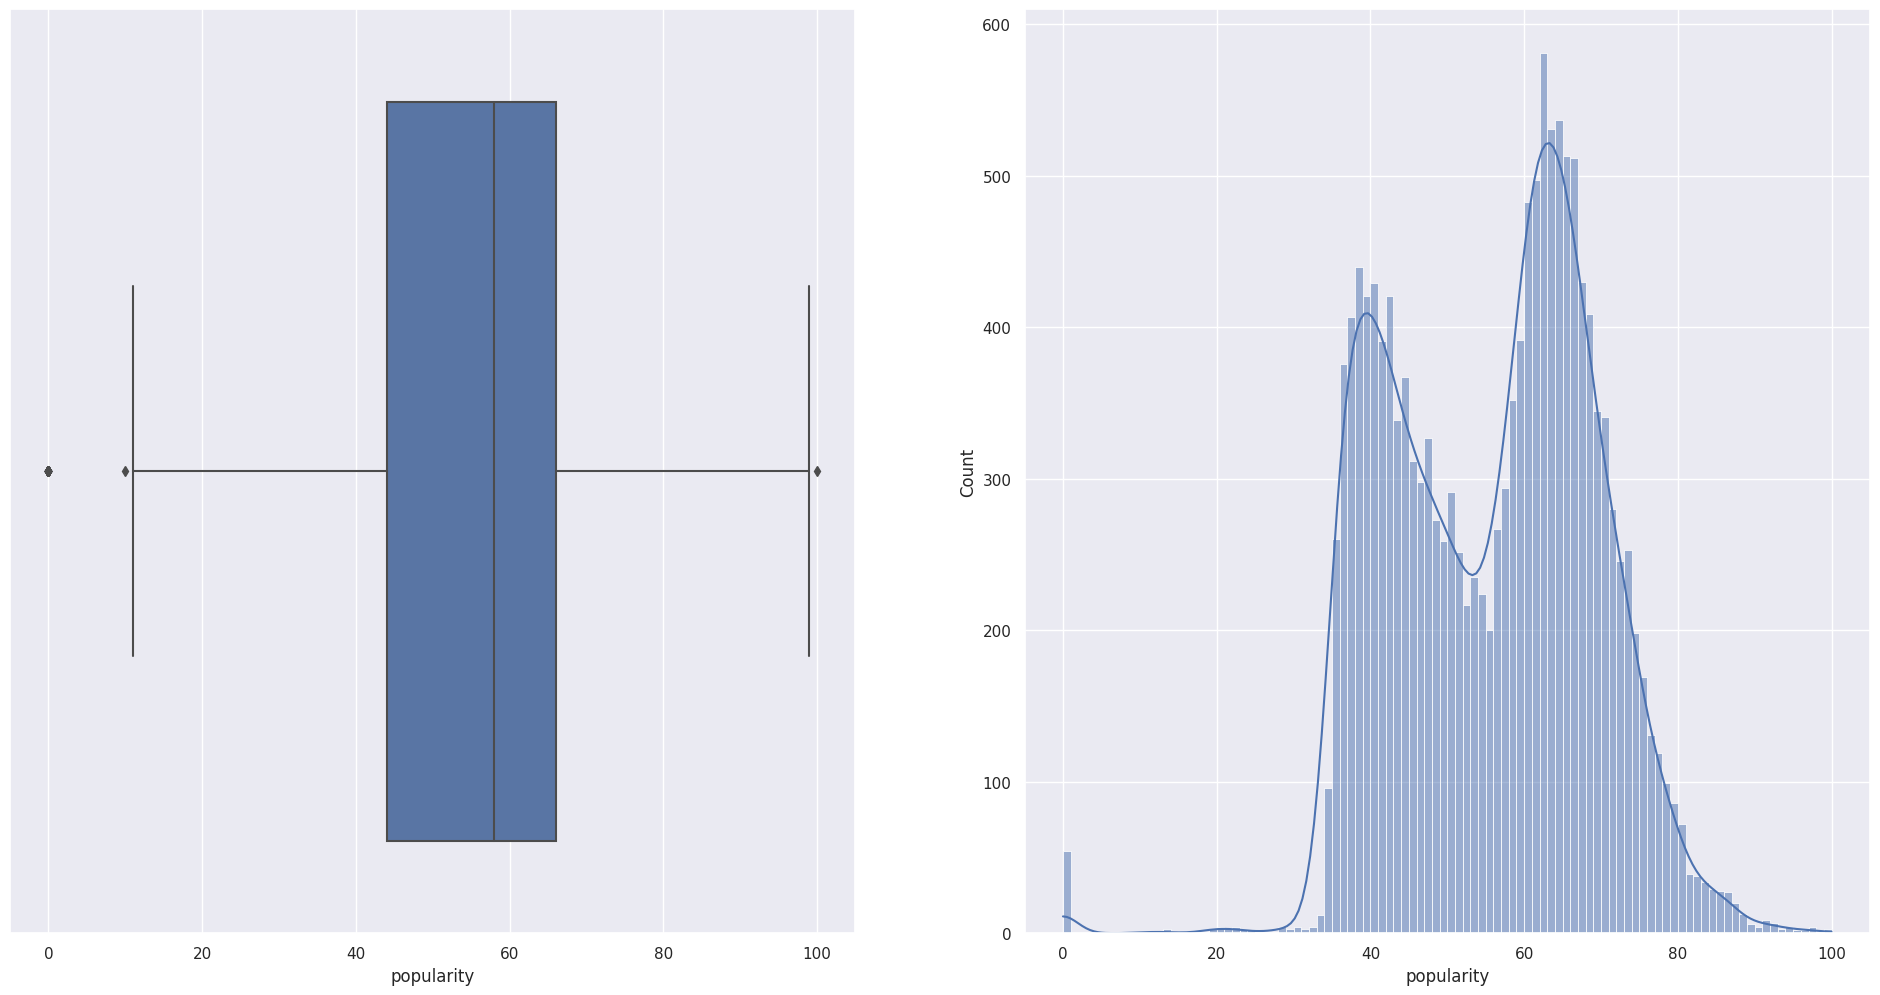

In [ ]:
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0]
pop_country["popularity"]

sb.boxplot(data=pop_country, x="popularity", orient="h", ax=axes[0] )
#Note that the binwidth is 10!
sb.histplot(data=pop_country, x="popularity", kde=True, binwidth=1, ax=axes[1] )

From the graphs above,  
**Boxplot**   
We can see that the outliers above the upper whiskers for are estimated to be above 90 and the those below the lower whiskers are estimated to be close to 0.

50% of the data is within around 45-65 `popularity` rating.  

**Histogram with density plot (histogram with KDE)**    
*Modality:* Bimodal distribution (two peaks)

*Skewness:* Negative skewness (Mean< Median< Mode) - highest peak on the right.

*Kurtosis:* Platykurtic (Negative kurtosis) indicates data is highly dispersed - Graph has flatter/shorter peak and thin tail (thin tail indicates lesser outliers). 

> Most rating are saturated at 35 to 60 and 60 to 70 out of 100.

We can cross check this with the summary descriptive statistics of `popularity`, the actual skewness and kurtosis of the plot as well as the value of the lower whiskers, upper whiskers and number of outliers.

In [ ]:
pop_country["popularity"].describe()

count    15353.000000
mean        55.759591
std         13.307986
min          0.000000
25%         44.000000
50%         58.000000
75%         66.000000
max        100.000000
Name: popularity, dtype: float64

In [ ]:
print("The skewness of popularity ", pop_country["popularity"].skew())
print("The kurtosis of popularity ", pop_country["popularity"].kurt())

The skewness of popularity  -0.20693792192613936
The kurtosis of popularity  -0.029527343256804617


In [ ]:
q1, q3 = pop_country["popularity"].quantile([0.25,0.75])#Finding Quantile 1 and Quantile 3
iqRange = q3 - q1 #Find the interquantile ranger
lower_whisker = q1 - (1.5*iqRange) #Finds value of lower whiskers
upper_whisker = q3 + (1.5*iqRange) #Finds value of Upper whiskers
NumOutliers = len(pop_country["popularity"][(pop_country["popularity"]<lower_whisker) | (pop_country["popularity"]>upper_whisker)]) 
print("value of lower whisker ", lower_whisker)
print("value of upper whisker ", upper_whisker)
print("Number of outliers for popularity ",NumOutliers)


value of lower whisker  11.0
value of upper whisker  99.0
Number of outliers for popularity  56


### `popularity` as categorical variable (`popularity_level`)
We want our prediction model to give us a range of values for popularity and hence, we transform `popularity` into a **categorical variable**.

Transforming popularity as a categorical data variable (ordinal type of categorical variable)

We are going to split the `popularity` rating into **5 different levels/categories** under a new `popularity_level` column:
- Low
- Medium Low
- Medium
- Medium High
- High

But there is a small problem! How are we going to split the `popularity` data into 5 different levels? Could we split the ratings into these 5 range `0-19`, `20-39`, `40-59`, `60-79`, `80-100`? However, from the above histogram with density plot, it seems like there is a significally low amount of data within the estimated range of `0-35` and `80-100`.  
As such we might encounter a class imbalance problem if we decide to split our data into the categories mentioned previously.  

Let's print out what excatly is the frequency for each of the `popularity` rating before finalising on the ranges.
___



Settings below are done so that we are able to glance through the frequencies of each `popularity` rating from `0-100`. We will reset back our display option later on after printing the frequency of each rating.

In [ ]:
# Setting display to print all rows
pd.set_option("display.max_rows",None)

In [ ]:
pop_country["popularity"].value_counts(sort=False) #sort=False so that values printed will not be sorted according to its frequency!

100      1
99       2
97       4
96       2
95       2
94       4
93       3
92       7
91       9
90       4
89       6
88      13
87      20
86      27
85      28
84      29
83      34
82      38
81      39
80      72
79      86
78      99
77     119
76     131
75     169
74     198
73     253
72     246
71     280
70     341
69     345
68     409
67     430
66     512
65     513
64     537
63     531
62     581
61     497
60     483
59     392
58     352
57     294
56     267
55     200
54     224
53     235
52     217
51     252
50     291
49     259
48     273
47     327
46     298
45     312
44     367
43     339
42     421
41     391
40     429
39     421
38     440
37     407
36     376
35     260
34      96
33      12
32       4
31       3
30       4
29       3
28       4
26       1
24       2
23       2
22       4
21       3
20       4
19       3
18       1
13       3
11       1
10       1
0       54
Name: popularity, dtype: int64

Note that the value on the left handside represents the popularity rating and the value on the right handside represent the frequency of that popularity rating.    
From the above, there is a significally low count/frequency from `0-34` and from `76-100`. As such we need to find another way to build our range so as to reduce problems due to class imbalance later on. 

Reset diplay settings to default

In [ ]:
pd.reset_option('^display.', silent=True)

**Finalising the range of values**   
Since we want to split `popularity` ratings into **5 different category** without having significant issues later due to class imbalance, we shall split our data equally into the 5 categories.

Each categories should have an estimate of around $\frac{15353}{5} = 3070.6$ entries.

Hence, we could split our data into the 5 categories as follows:

In [200]:
#Creating new column to store popularity as category
pop_country["popularity_level"] = 0 #'Low'

pop_country.loc[(pop_country["popularity"]>=42) & (pop_country["popularity"]<=51), "popularity_level"] = 1  #'Medium Low'
pop_country.loc[(pop_country["popularity"]>=52) & (pop_country["popularity"]<=61), "popularity_level"] = 2  #'Medium'
pop_country.loc[(pop_country["popularity"]>=62) & (pop_country["popularity"]<=67), "popularity_level"] = 3  #'Medium High'
pop_country.loc[(pop_country["popularity"]>=68) & (pop_country["popularity"]<=100), "popularity_level"] = 4 #'High'

pop_country["popularity_level"].value_counts()

2    3161
1    3139
3    3104
4    3020
0    2929
Name: popularity_level, dtype: int64

Note that the value on the left handside represents the popularity rating and the value on the right handside represent the frequency of that popularity rating. 

**Visualising `popularity` as a categorical variable**  
Checking the balance of classes visually.

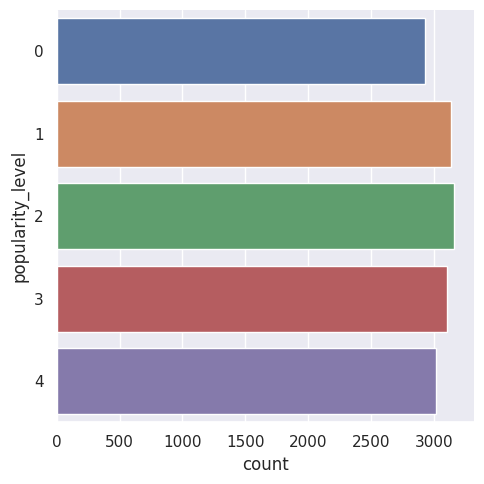

In [203]:
sb.catplot(y="popularity_level", data=pop_country, kind="count")

Alright very nice, we can see from the above that `popularity` have been quite evenly categoried into 5 categories under `popularity_level`.

### Visualising and analysing Numerial General Music features individually (using Uni-Variate plots)

Applying Boxplots and Histogram with density plot on each of the numerical variable.

#### Why boxplot?
To visualise lower and upper tier outliers, as well as the medium and interquartile ranges.

#### Why histogram and density plot?
Provides us information of the frequency of the data variable as well as shows us how the distribution is like (shape of distribution, skewness and kertosis)

**Note**  
*Modality:* Number of peeks in a dataset (**unimodal:** one peak- eg. normal Distribution curve, **bimodal:** two peaks, **multimodal:** multiple peaks)

*Skewness of density plot:* Skewness is a measure of a lack of symmetry.

*Kurtosis of density plot:* Kurtosis is a tells us of the data is heavy-tailed or light-tailed relative to a normal distribution curve.

### Visualising and Analysing `duration_ms`

`duration_ms` : The duration of the track in milliseconds.

<Axes: xlabel='duration_ms', ylabel='Count'>

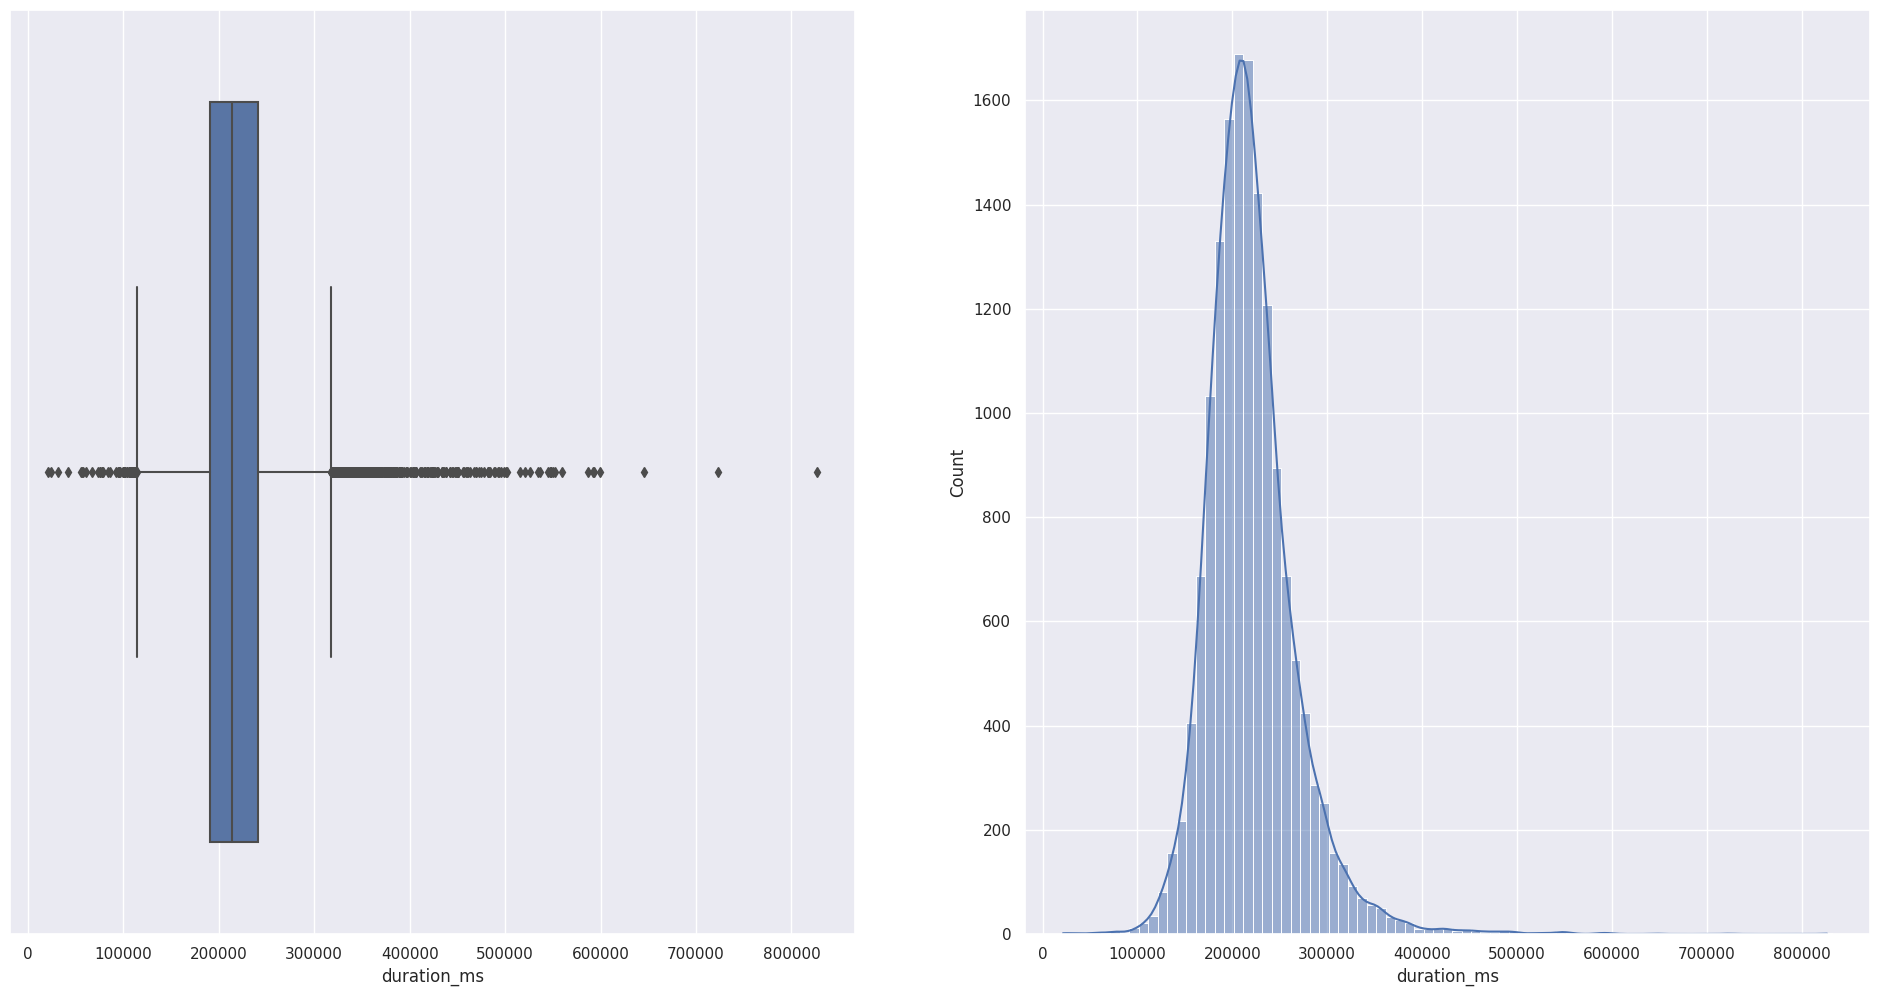

In [ ]:
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0]
pop_country["duration_ms"]

sb.boxplot(data=pop_country, x="duration_ms", orient="h", ax=axes[0] )
#Note that the binwidth is 10!
sb.histplot(data=pop_country, x="duration_ms", kde=True, binwidth=10000, ax=axes[1] )

From the above graphs,  
**Boxplot:**   
Shows us that track outliers have a `duration_ms` of either below around 100000ms or above around 320000ms.  
**histogram with density plot:**  
*Modality:* Unimodal  
*Skewness:* Positive skew (Mode< Median< Mean) - Graph slants to the left.  
*Kurtosis:* Leptokurtic (Positive kurtosis) indicates less variability (data clustered together) - Graph has sharp peak and flat tail (fat tail indicates relatively more outliers).  
*Special note:* The `duration_ms` of most songs are saturated at around 190000ms to 240000ms.

Let's also cross check with summary descriptive statistics of `duration_ms`, the actual skewness and kurtosis of the plot as well as the value of the lower whiskers, upper whiskers and number of outliers.

In [ ]:
pop_country["duration_ms"].describe()

count     15353.000000
mean     219754.116069
std       47090.260304
min       21547.000000
25%      190417.000000
50%      213939.000000
75%      241240.000000
max      826813.000000
Name: duration_ms, dtype: float64

In [ ]:
print("The skewness of duration_ms ", pop_country["duration_ms"].skew())
print("The kurtosis of duration_ms ", pop_country["duration_ms"].kurt())

The skewness of duration_ms  1.5782183299439267
The kurtosis of duration_ms  8.236144050957474


In [ ]:
q1, q3 = pop_country["duration_ms"].quantile([0.25,0.75])   #Finding Quantile 1 and Quantile 3
iqRange = q3 - q1                                           #Find the interquantile ranger
lower_whisker = q1 - (1.5*iqRange)                          #Finds value of lower whiskers
upper_whisker = q3 + (1.5*iqRange)                          #Finds value of Upper whiskers
NumOutliers = len(pop_country["duration_ms"][(pop_country["duration_ms"]<lower_whisker) | (pop_country["duration_ms"]>upper_whisker)])
print("value of lower whisker ", lower_whisker)
print("value of upper whisker ", upper_whisker) 
print("Number of outliers for duration_ms ",NumOutliers)

value of lower whisker  114182.5
value of upper whisker  317474.5
Number of outliers for duration_ms  554


###**Visualising and analysing `loudness`**  
`loudness`: The overall loudness of a track in decibels(dB).

`loudness` is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db.

<Axes: xlabel='loudness', ylabel='Count'>

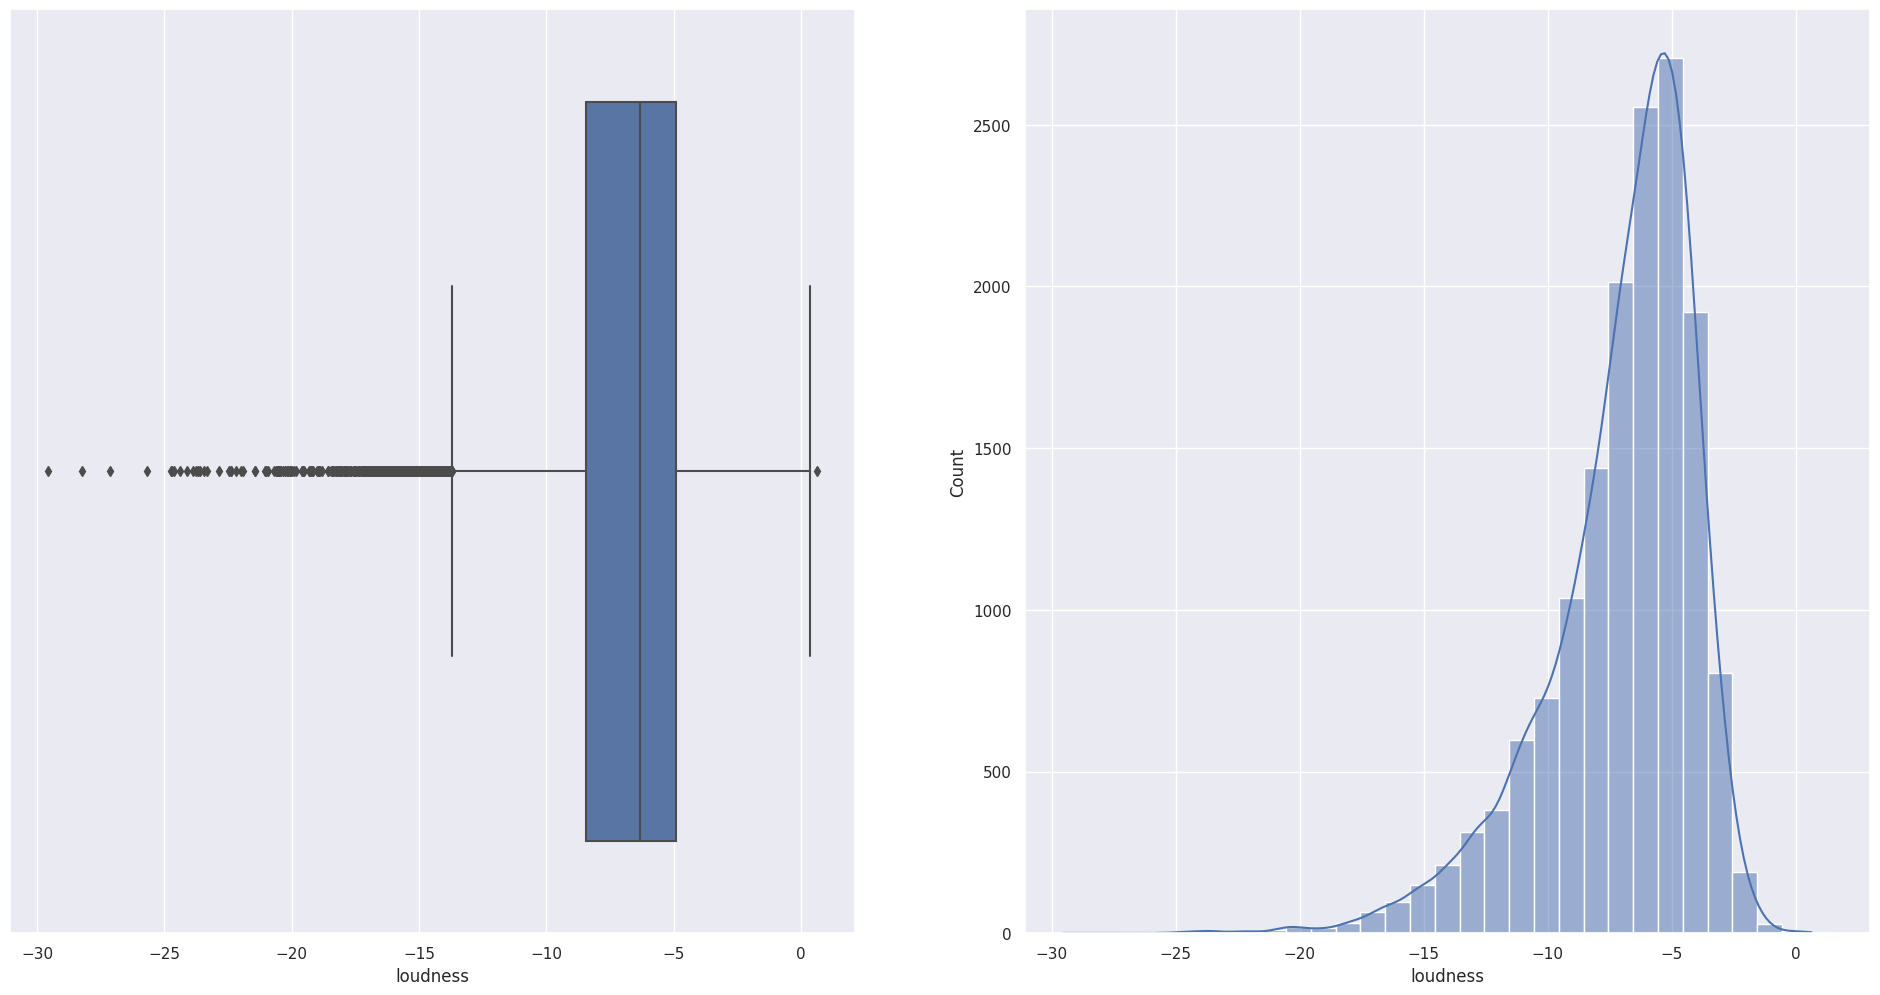

In [ ]:
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0]
pop_country["loudness"]

sb.boxplot(data=pop_country, x="loudness", orient="h", ax=axes[0] )
# Note that the binwidth is 10!
sb.histplot(data=pop_country, x="loudness", kde=True, binwidth=1, ax=axes[1] )
# sb.violinplot(data=pop_country, x="loudness", orient="h", ax=axes[2] )

From the above graphs,  
**Boxplot:**   
Shows us that all outliers are outside the lower whisker. The outliers have `loudness` of around -15dB and below.   
**histogram with density plot:**  
*Modality:* Unimodal  
*Skewness:* Negative skew (Mean< Median< Mode) - Graph slants to the right.  
*Kurtosis:* Leptokurtic (Positive kurtosis) indicates less variability (data clustered together) - Graph has sharp peak and flat tail on the left side(left slide would have relatively more outliers).  
*Special note:* The `loudness` of most songs are saturated at around -5dB to -8dB

Let's also cross check with summary descriptive statistics of `loudness` and the actual skewness and kurtosis of the plot as well as the value of the lower whiskers, upper whiskers and number of outliers.

In [ ]:
pop_country["loudness"].describe()

count    15353.000000
mean        -7.009507
std          3.056010
min        -29.554000
25%         -8.422000
50%         -6.322000
75%         -4.902000
max          0.634000
Name: loudness, dtype: float64

In [ ]:
print("The skewness of loudness ", pop_country["loudness"].skew())
print("The kurtosis of loudness ", pop_country["loudness"].kurt())

The skewness of loudness  -1.3453004008318807
The kurtosis of loudness  2.814072115751552


In [ ]:
q1, q3 = pop_country["loudness"].quantile([0.25,0.75])#Finding Quantile 1 and Quantile 3
iqRange = q3 - q1 #Find the interquantile ranger
lower_whisker = q1 - (1.5*iqRange) #Finds value of lower whiskers
upper_whisker = q3 + (1.5*iqRange) #Finds value of Upper whiskers
NumOutliers = len(pop_country["loudness"][(pop_country["loudness"]<lower_whisker) | (pop_country["loudness"]>upper_whisker)]) 
print("value of lower whisker ", lower_whisker)
print("value of upper whisker ", upper_whisker)
print("Number of outliers for loudness ", NumOutliers)

value of lower whisker  -13.702000000000002
value of upper whisker  0.378000000000001
Number of outliers for loudness  588


###**Visualising and analysing `tempo`**  
`tempo`: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.


<Axes: xlabel='tempo', ylabel='Count'>

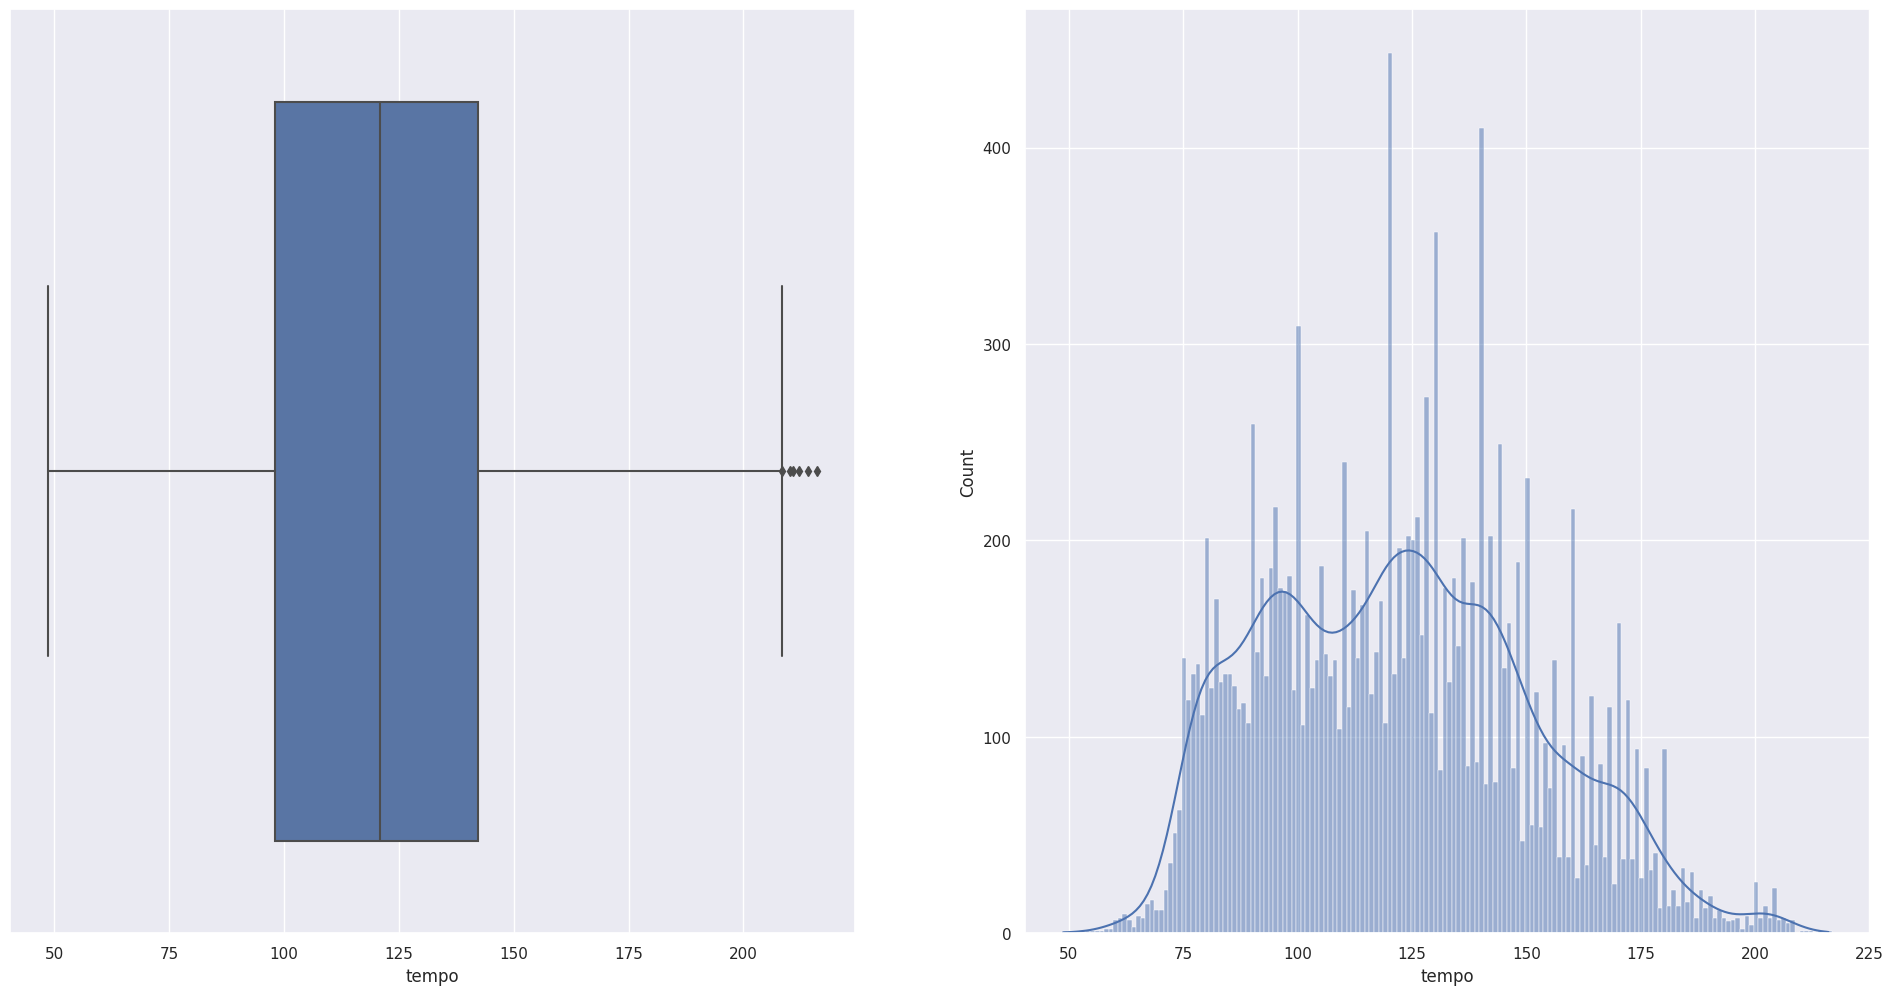

In [ ]:
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0]
pop_country["tempo"]

sb.boxplot(data=pop_country, x="tempo", orient="h", ax=axes[0] )
#Note that the binwidth is 10!
sb.histplot(data=pop_country, x="tempo", kde=True, binwidth=1, ax=axes[1] )
# sb.violinplot(data=pop_country, x="tempo", orient="h", ax=axes[2] )

From the above graphs,  
**Boxplot:**   
Shows us that all outliers are outside the upper whisker. The outliers have `tempo` of greater than 200.   
**histogram with density plot:**  
*Modality:* Multimodal  
*Skewness:* Positive skew (Mode< Median< Mean) - Graph slants to the right.  
*Kurtosis:* Platykurtic (Negative kurtosis) indicates data is highly dispersed - Graph has flatter/shorter peaks and thin tail (thin tail indicates lesser outliers). 

Let's also cross check with summary descriptive statistics of `tempo` and the actual skewness and kurtosis of the plot as well as the value of the lower whiskers, upper whiskers and number of outliers.

In [ ]:
pop_country["tempo"].describe()

count    15353.000000
mean       122.180557
std         29.445751
min         48.718000
25%         98.008000
50%        120.993000
75%        142.134000
max        216.029000
Name: tempo, dtype: float64

In [ ]:
print("The skewness of tempo ", pop_country["tempo"].skew())
print("The kurtosis of tempo ", pop_country["tempo"].kurt())

The skewness of tempo  0.3056954113604608
The kurtosis of tempo  -0.5324737959319017


In [ ]:
q1, q3 = pop_country["tempo"].quantile([0.25,0.75])#Finding Quantile 1 and Quantile 3
iqRange = q3 - q1 #Find the interquantile ranger
lower_whisker = q1 - (1.5*iqRange) #Finds value of lower whiskers
upper_whisker = q3 + (1.5*iqRange) #Finds value of Upper whiskers
NumOutliers = len(pop_country["tempo"][(pop_country["tempo"]<lower_whisker) | (pop_country["tempo"]>upper_whisker)]) 
print("value of lower whisker ", lower_whisker)
print("value of upper whisker ", upper_whisker)
print("Number of outliers for tempo ", NumOutliers)

value of lower whisker  31.819000000000003
value of upper whisker  208.32299999999998
Number of outliers for tempo  6


## Visualising dispersion of General Music features with `popularity`


**Historgam with Density Plot (KDE)**

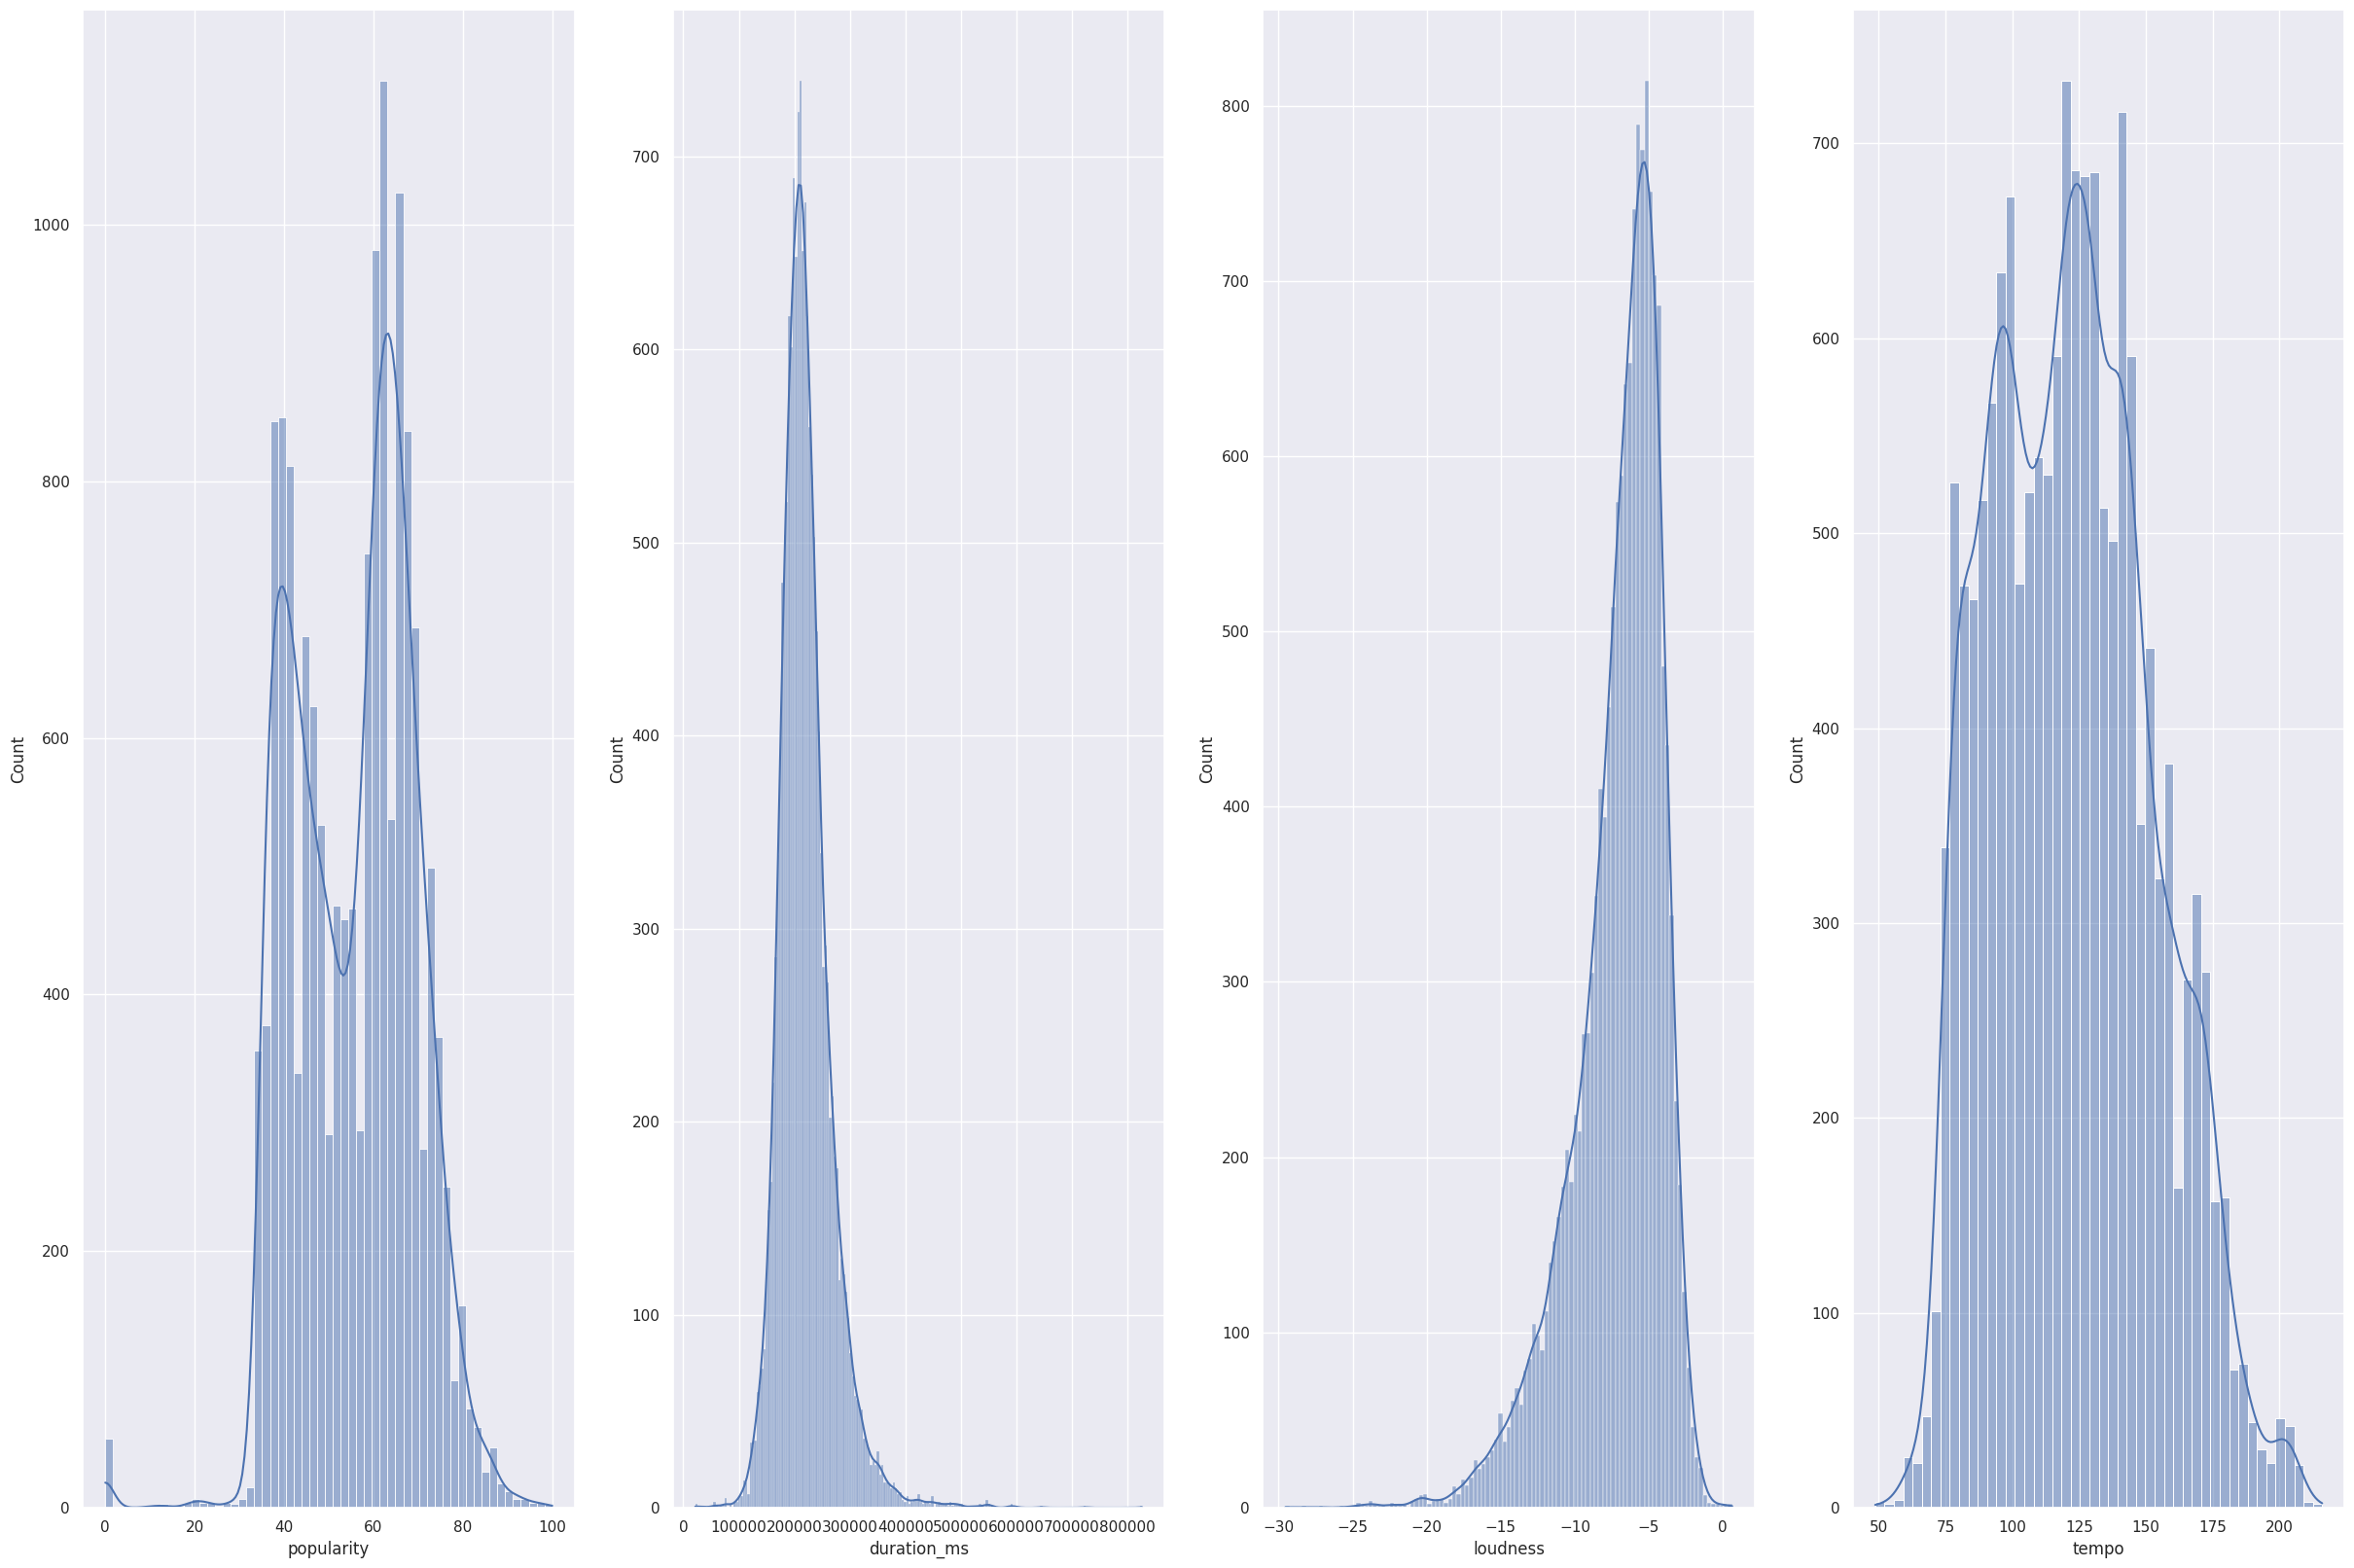

In [ ]:
f, axes = plt.subplots(1,4, figsize=(30,20))
count = -1
for feature in ["popularity", "duration_ms", "loudness", "tempo"]:
    count+= 1
    sb.histplot(data=pop_country[feature], kde=True, ax=axes[count])

In [ ]:
for col in pop_country[["popularity", "duration_ms", "loudness", "tempo"]]:
    print(f"The skewness of {col} is: {pop_country[col].skew()}") 
#skew() returns the value of skewness

The skewness of popularity is: -0.20693792192613936
The skewness of duration_ms is: 1.5782183299439267
The skewness of loudness is: -1.3453004008318807
The skewness of tempo is: 0.3056954113604608


**Boxplot**

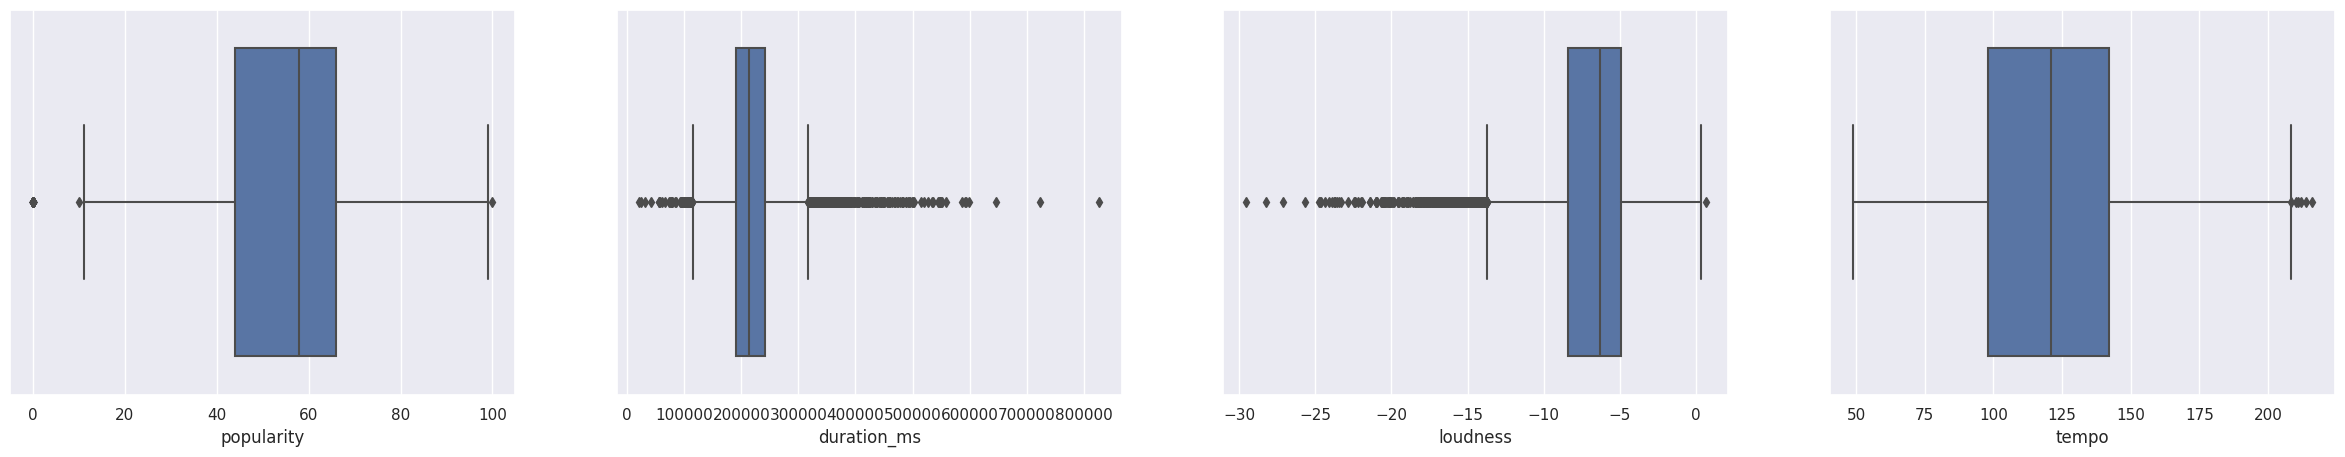

In [ ]:
f, axes = plt.subplots(1,4, figsize=(30,5))
count = -1
for feature in pop_country[["popularity", "duration_ms", "loudness", "tempo"]]:
    count+= 1
    sb.boxplot(data = pop_country, x=feature, orient = "h", ax = axes[count])

## Finding and visualising correlation between numerical variables and `popularity`

### Visualising correlation using Scatter Plot

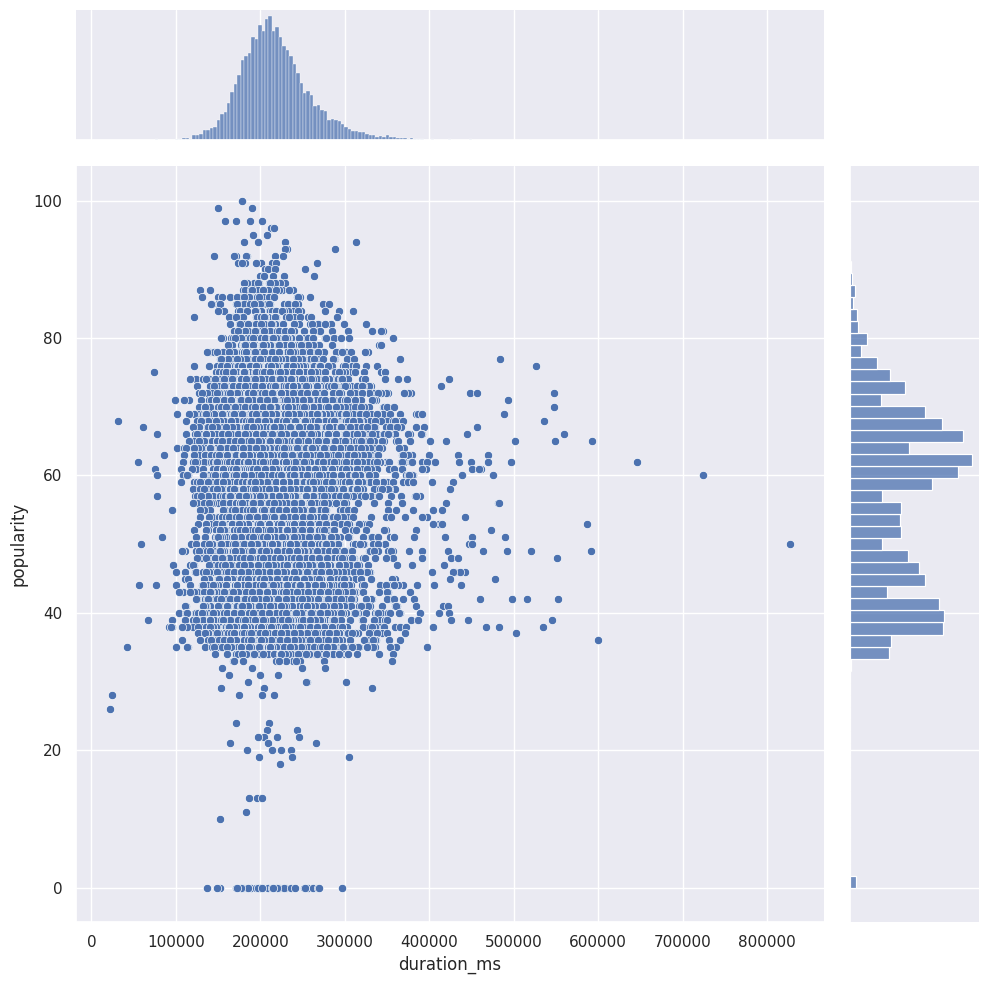

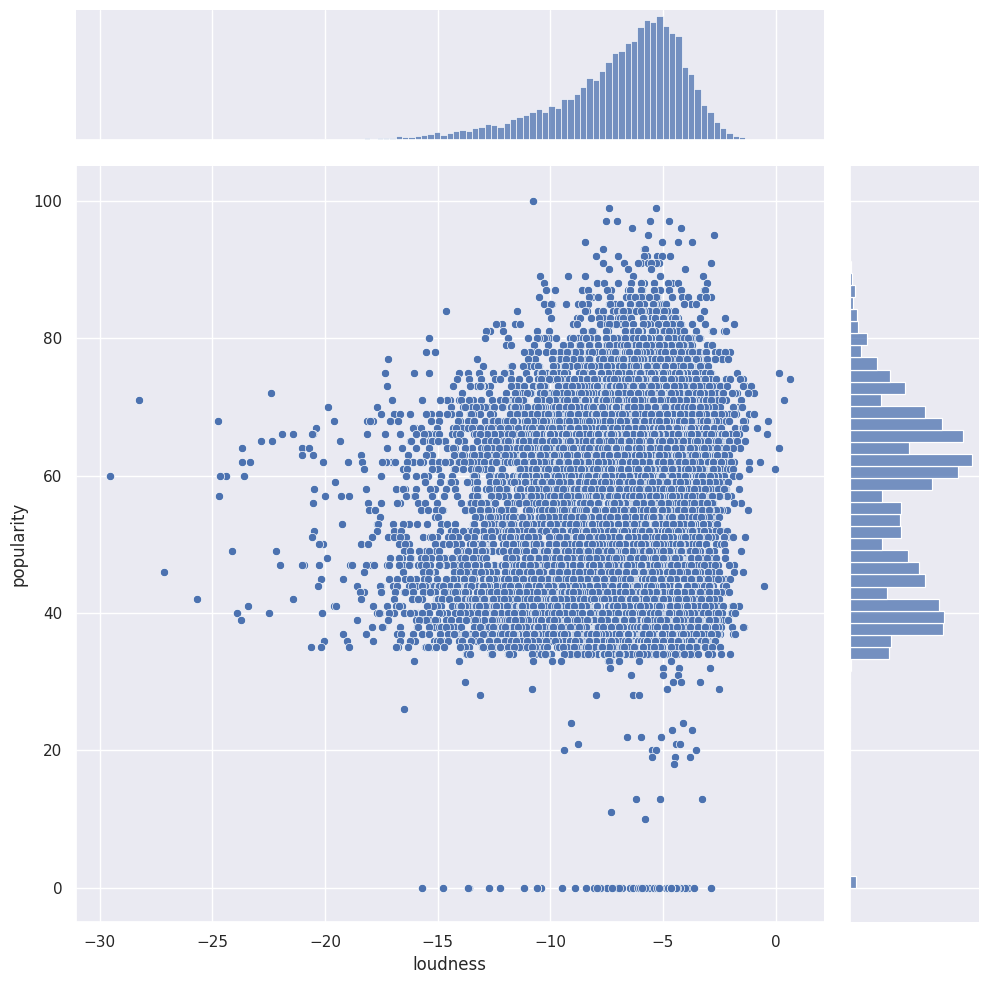

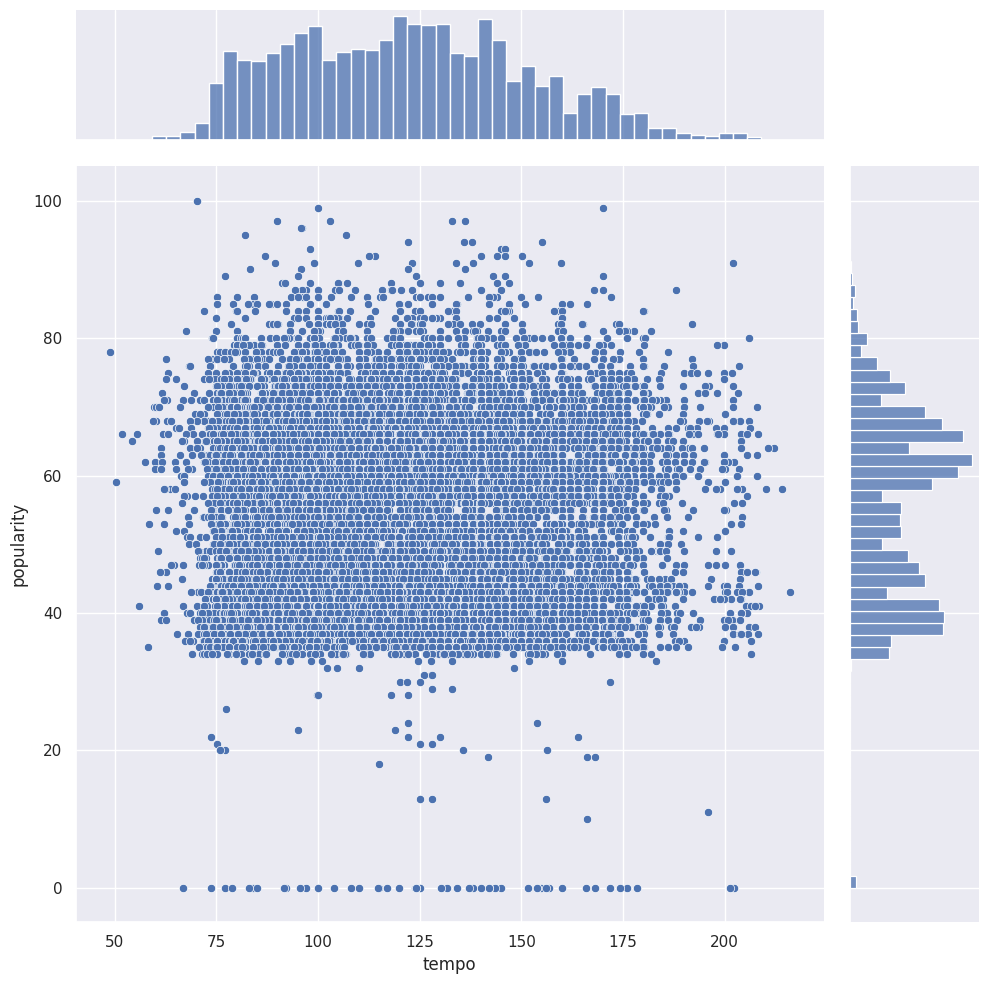

In [ ]:
for feature in ["duration_ms", "loudness", "tempo"]:
  sb.jointplot(data=pop_country, x=pop_country[feature] , y="popularity", height = 10)

Seems like there isn't any correlation between the numerical variables and `popularity`

###**Calculating correlation between numerical variables and `popularity`**

In [ ]:
print("Correlation Coefficient")
for feature in ["duration_ms", "loudness", "tempo"]:
    print(f"{feature}: {pop_country[feature].corr(pop_country['popularity'])}")

Correlation Coefficient
duration_ms: 0.034840283310786056
loudness: 0.11717582716315295
tempo: -0.03928897674473394


### Best Numerical Predictor
Based on calculations, all of the numerical variables does not seem to have good correlation with `popularity`, even though the data variable `loudness` has the best correlation with `popularity`, the value of correlation is not even 0.1.

**As a desperate measure, let's check the coorelation between Spotify specified numberical variables with `popularity`**

In [ ]:
print("Correlation Coefficient")
for feature in ["acousticness","danceability","energy","liveness","speechiness","valence"]:
    print(f"{feature}: {pop_country[feature].corr(pop_country['popularity'])}")

Correlation Coefficient
acousticness: -0.08331487208709283
danceability: 0.21135158030057963
energy: 0.020561913996564884
liveness: -0.04740360801519499
speechiness: 0.25784795248176096
valence: -0.08752046039207362


### Visualising correlation between all numerical variables using Heatmap

Check if there are any correlation between the numerical general music variables

<Axes: >

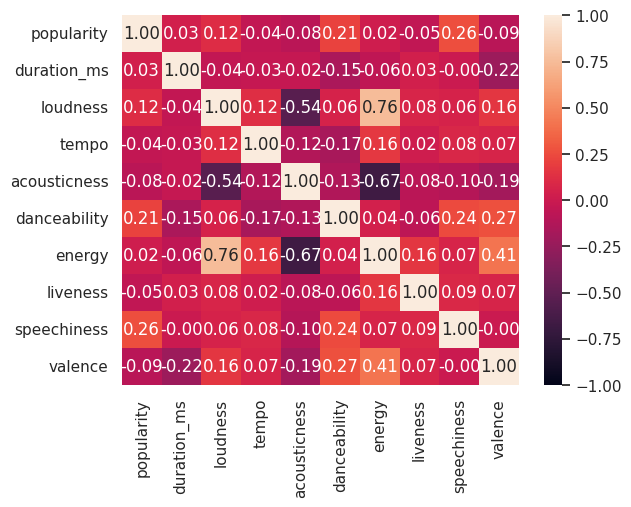

In [ ]:
display_data = pop_country[["popularity", "duration_ms", "loudness", "tempo","acousticness","danceability","energy","liveness","speechiness","valence"]]
sb.heatmap(display_data.corr(), vmin = -1, vmax = 1, annot = True, fmt=".2f") 

Based on the heatmap, it seems like there isn't any significant correlation between the numerical variables,  other than the correlation between `loudness` and `energy` which is not our main purpose.

Our main purpose is to find significant correlation between a numercial variable with `popularity`

Hence, perhaps we should not use these variables for our prediction later.

## Analysing Categorical General Music Features


### Univariate Analysis: General Music Features (Categorical) 

Count plots will be used to visualise the distribution of levels in each categorical variable.

#### Distribution: `keys`

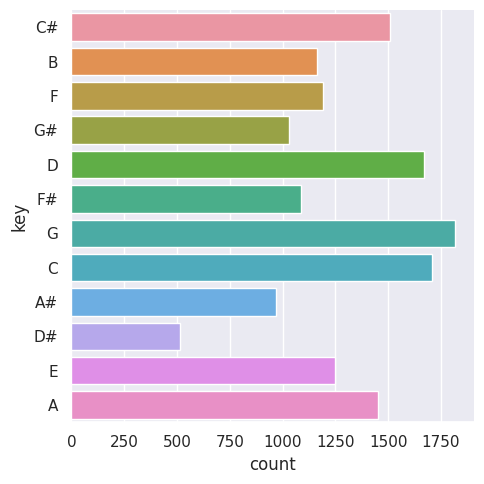

In [ ]:
sb.catplot(y="key", data=pop_country, kind="count")

This class seems to be a little imbalanced.

#### Distribution: `mode`

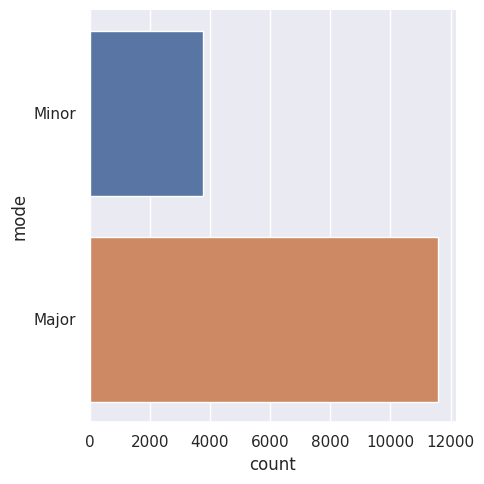

In [ ]:
sb.catplot(y="mode", data=pop_country, kind="count")

Base on the above count plot, the class seems to be significantly imbalanced.

#### Distribution: `time_signature`

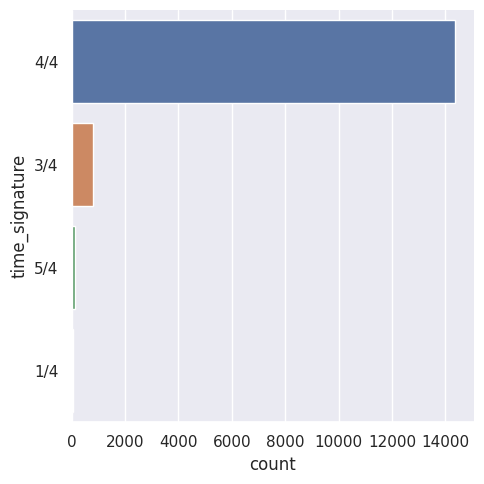

In [ ]:
sb.catplot(y="time_signature", data=pop_country, kind="count")

Base on the above count plot, the class seems to be significally imbalanced.

In [ ]:
pop_country["time_signature"].value_counts()

4/4    14354
3/4      813
5/4      142
1/4       44
Name: time_signature, dtype: int64

#### Composite Variable: `modal_key`

Rational for creating this new variable: In general it is more common to have songs categoriesd in terms of it's key and mode (major/minor) together instead of having it's key and mode seperated.

In [ ]:
pop_country["modal_key"] = pop_country["key"] + " " + pop_country["mode"]

#### Distribution: `modal_keys`

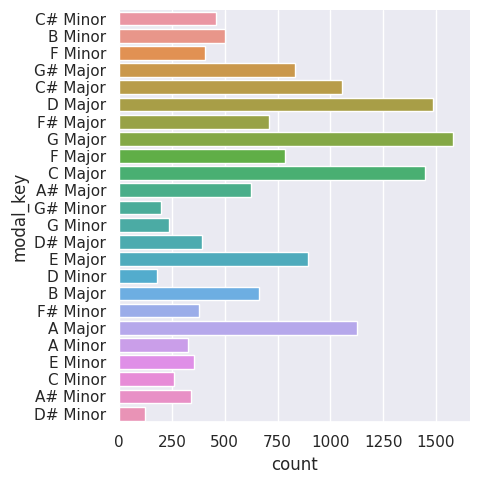

In [ ]:
sb.catplot(y="modal_key", data=pop_country, kind="count")

Base on the above count plot, the class seems to be a little imbalanced.

### Visualising and analysing relationship of categorical data with `popularity`

Boxplots and heatmap will be used help us visualise the relationship between each categorical variable and `popularity`.

#### Distribution: `key` vs `popularity`

**Boxplot**

<Axes: xlabel='popularity', ylabel='key'>

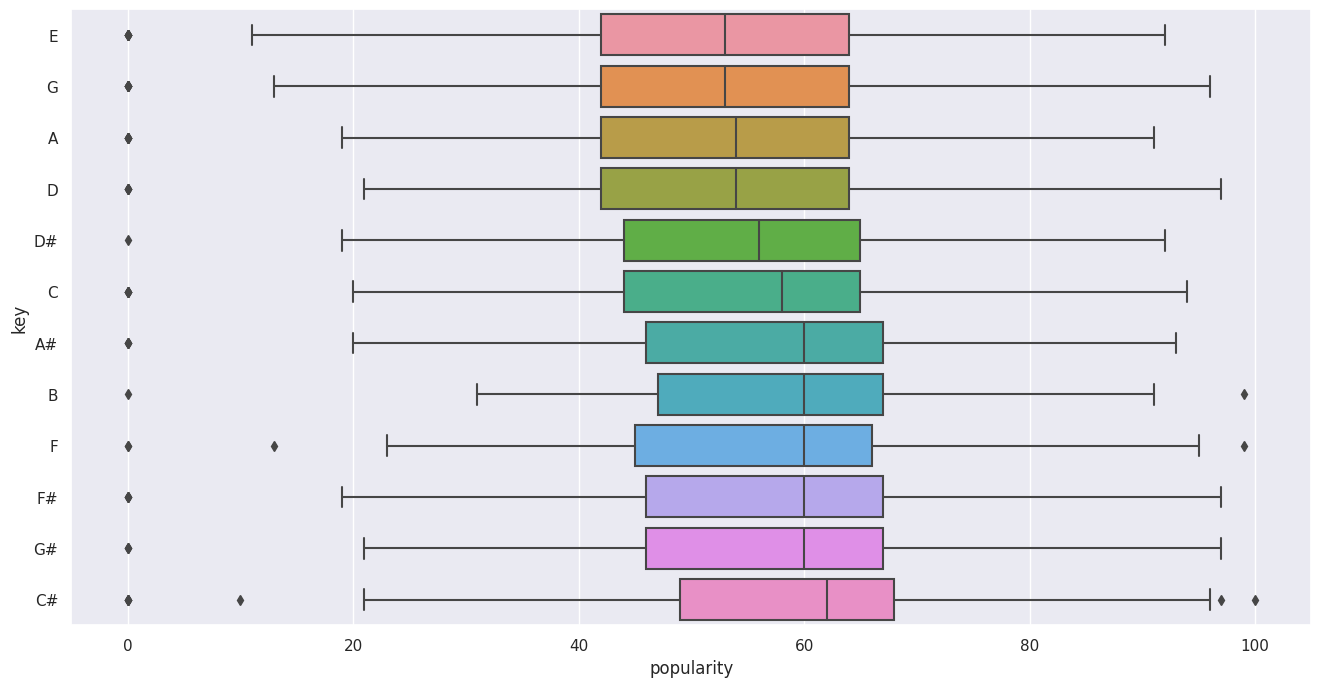

In [ ]:
# Relationship between popularity and keys
f, axes = plt.subplots(1, figsize=(16, 8))
keySubClassSort = pop_country.groupby("key")["popularity"].median().sort_values().index
sb.boxplot(x="popularity", y="key", data=pop_country, order = keySubClassSort)

**Heatmap**  
Comparing with `popularity_level` instead with the `popularity` (bi-varient exploration, comparing classes)

<Axes: xlabel='key', ylabel='popularity_level'>

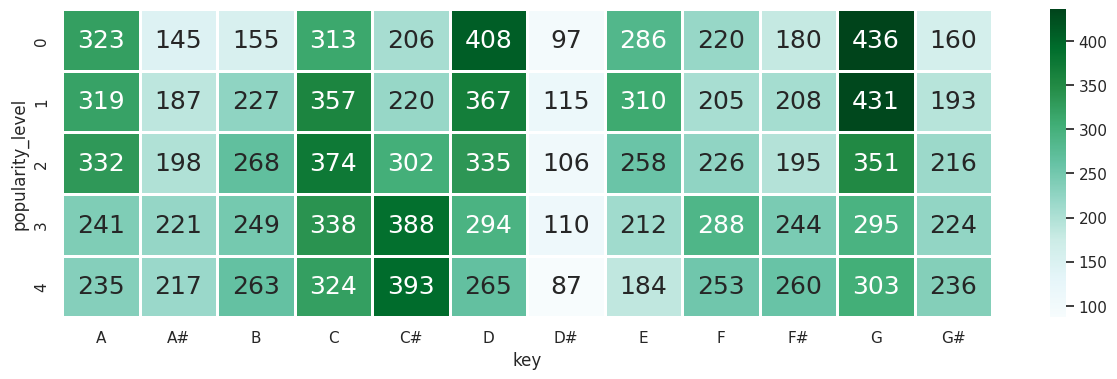

In [ ]:
# popularity_level vs key
f = plt.figure(figsize=(15, 4))
sb.heatmap(pop_country.groupby(["popularity_level", "key"]).size().unstack(), 
           linewidths = 1, annot = True, fmt = 'g', annot_kws = {"size": 18}, cmap = "BuGn")

**Visualising and Analysing the distribution of the `mode` of the tracks against `popularity`**

<Axes: xlabel='popularity', ylabel='mode'>

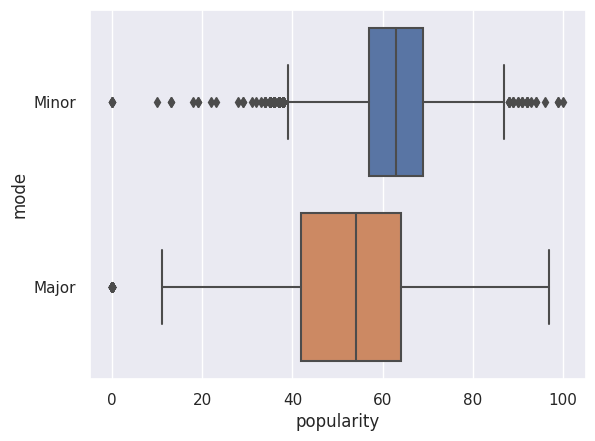

In [ ]:
sb.boxplot(data=pop_country, y="mode", x="popularity", orient="h")

From the above count plot, it seems like `mode` many have some correlation with `popularity`.

Minor `mode` seems to have a significally higher `popularity` rating than major `mode` (roughtly about 20 rating higher)

**Heatmap**  
Comparing with `popularity_level` instead with the `popularity` (bi-varient exploration, comparing classes)

<Axes: xlabel='mode', ylabel='popularity_level'>

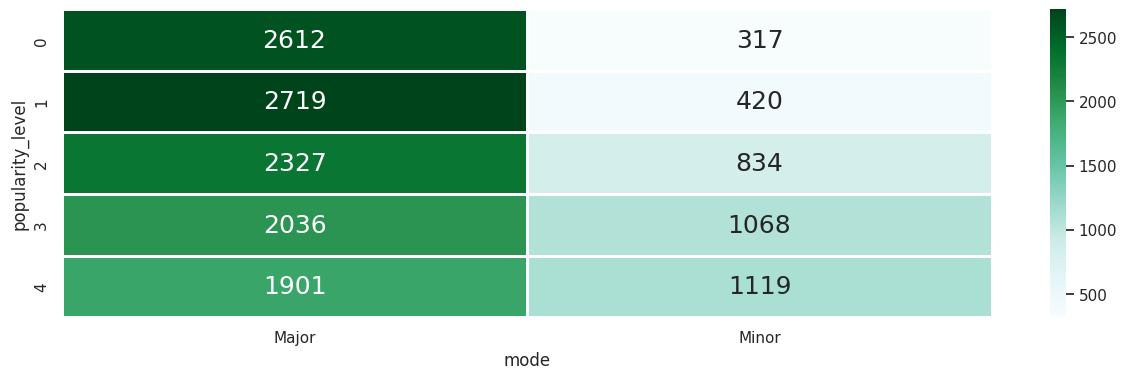

In [ ]:
# popularity_level vs mode
f = plt.figure(figsize=(15, 4))
sb.heatmap(pop_country.groupby(["popularity_level", "mode"]).size().unstack(), 
           linewidths = 1, annot = True, fmt = 'g', annot_kws = {"size": 18}, cmap = "BuGn")

#### Distribution: `time_signature` vs `popularity`

<Axes: xlabel='popularity', ylabel='time_signature'>

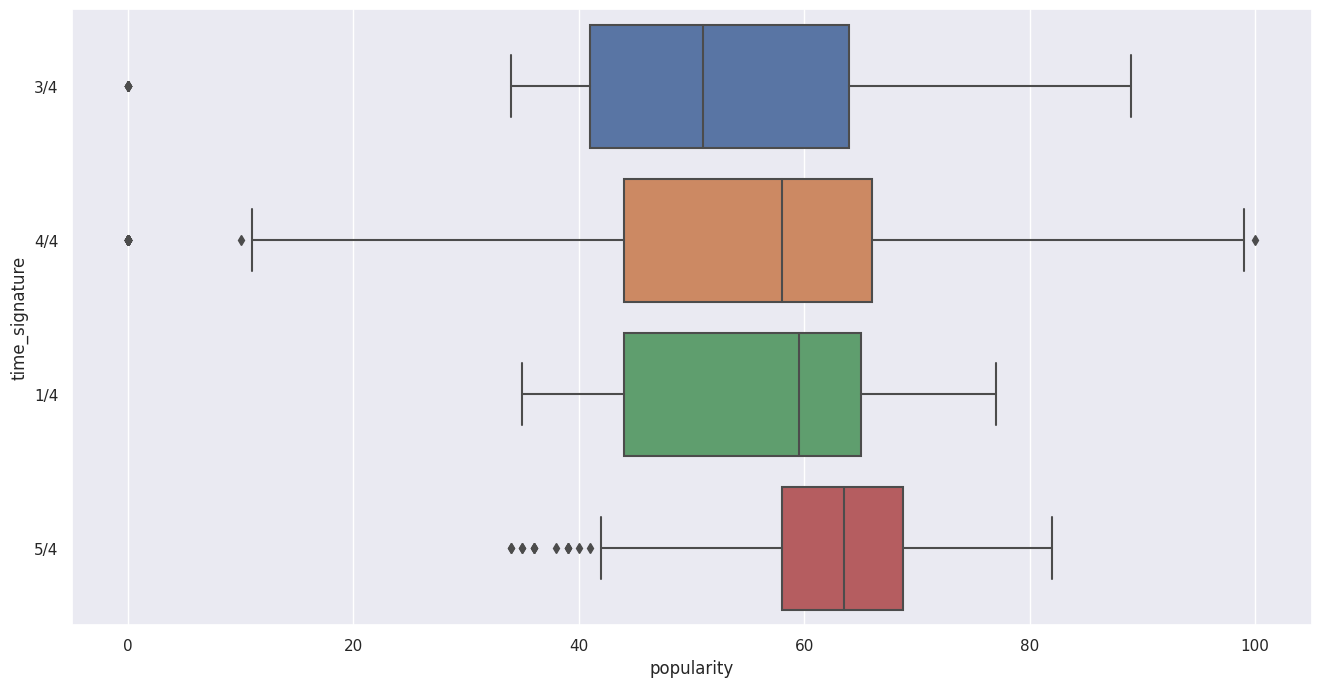

In [ ]:
f, axes = plt.subplots(1, figsize=(16, 8))
time_signature_SubClassSort = pop_country.groupby("time_signature")["popularity"].median().sort_values().index
sb.boxplot(x="popularity", y="time_signature", data=pop_country, order = time_signature_SubClassSort)

**Heatmap**  
Comparing with `popularity_level` instead with the `popularity` (bi-varient exploration, comparing classes)

<Axes: xlabel='time_signature', ylabel='popularity_level'>

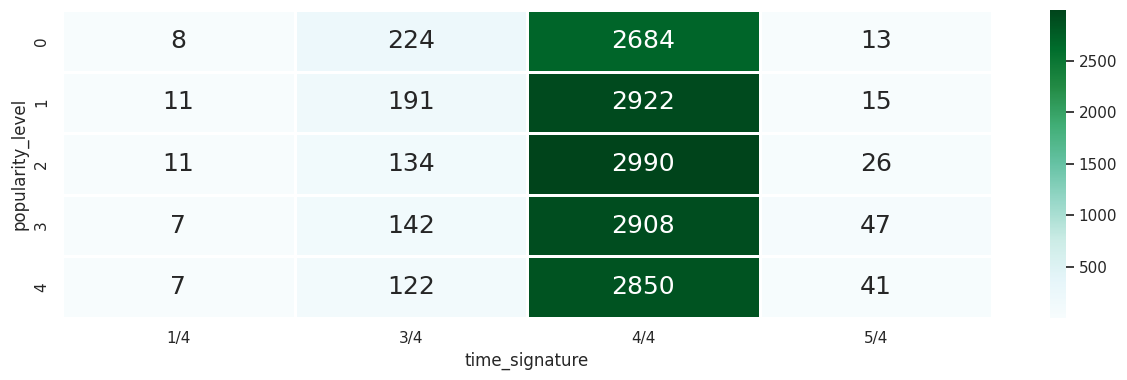

In [ ]:
# popularity_level vs mode
f = plt.figure(figsize=(15, 4))
sb.heatmap(pop_country.groupby(["popularity_level", "time_signature"]).size().unstack(), 
           linewidths = 1, annot = True, fmt = 'g', annot_kws = {"size": 18}, cmap = "BuGn")

#### Distribution: `modal_key` vs `popularity`

**Boxplot**

<Axes: xlabel='popularity', ylabel='modal_key'>

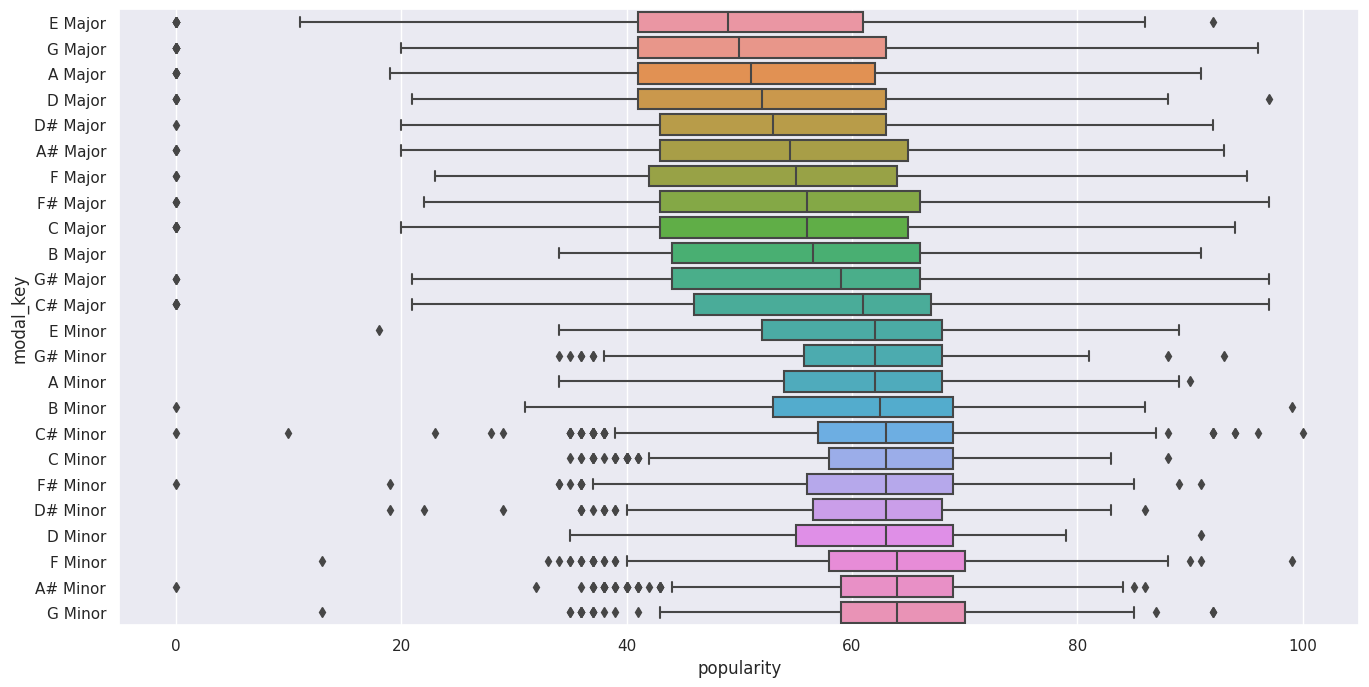

In [ ]:
# Relationship between popularity and modal_key
f, axes = plt.subplots(1, figsize=(16, 8))
time_signature_SubClassSort = pop_country.groupby("modal_key")["popularity"].median().sort_values().index
sb.boxplot(x="popularity", y="modal_key", data=pop_country, order = time_signature_SubClassSort)

**Heatmap**

<Axes: xlabel='modal_key', ylabel='popularity_level'>

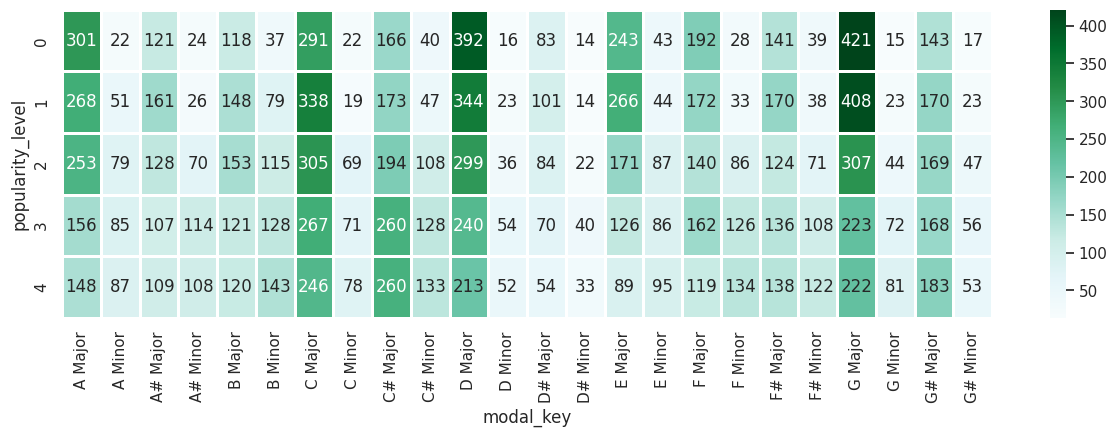

In [ ]:
# popularity_level vs mode
f = plt.figure(figsize=(15, 4))
sb.heatmap(pop_country.groupby(["popularity_level", "modal_key"]).size().unstack(), 
           linewidths = 1, annot = True, fmt = 'g', annot_kws = {"size": 12}, cmap = "BuGn")

## Best Predictors
Based on the analysis we are unable to find significant correlation between numerical variables and popularity.

Whereas, for categorical variable, it seem that only `mode` has a slighly correlation with popularity.

We think maybe the popularity of a song is based on something else entirely.

## Obtaining Lyrics
We think that the **lyrics** of a song gives it meaning and should contribute quite a bit to it's popularity.

However, Spotify doesn't provide us with lyrics, so we decided to scrape it from the lyrics site [Genius](https://genius.com/).

This will be a huge time bottleneck in the project (> 200,000 songs).
We decided to reduce the dataset size to **focus only on Pop and Country** music since that is the 2 genres we are most interesting in!

Of course, to run the code in this section, you'll have to replace the below **API token** with your own Genius API Token.

In [ ]:
GENIUS_TOKEN = "NOT-GONNA-GIVE-YOU-MY-API-TOKEN"

A query request will be given as such,

In [ ]:
headers = {"Authorization": f"Bearer {GENIUS_TOKEN}"}
params = {"q": "Adele Rolling In The Deep"}

r = requests.get("https://api.genius.com/search", params=params, headers=headers)

The response is in JSON, with the following structure:  
(condensed to only include the information we need)

```json
{
  "meta": {
    "status": 200
  },
  "response": {
    "hits": [
      {
        "highlights": [],
        "index": "song",
        "type": "song",
        "result": {
          "artist_names": "Adele",
          "full_title": "Someone Like You by Adele",
          "language": "en",
          "lyrics_state": "complete",
          "title": "Someone Like You",
          "url": "https://genius.com/Adele-someone-like-you-lyrics",
           ...
          }
        },
       ...
    ]
  }
}
```

Then to extract the information we want we can do the following

In [ ]:
r_json = r.json()
song = r_json["response"]["hits"][0]["result"]

lyrics_artist = song["artist_names"]
lyrics_title = song["title"]
lyrics_lang = song["language"]
lyrics_state = song["lyrics_state"]
lyrics_url = song["url"]

Notice that Genius **doesn't give us the lyrics as plaintext**, but instead gives us a URL to the lyrics on their Website.

Hence, we will be scrapping the site with **BeautifulSoup** to extract the lyrics.

#### Lyrics Class

As of 2023, inspection on their site revealed that lyrics are stored under a `<div class="Lyrics__Container-sc-1ynbvzw-5 Dzxov" ...>` container.

The strings in each of these containers forms the lyrics, which we can easily get with BeautifulSoup's `.strings`.

Note that there could be multiple of such containers in the site if the lyrics are seperated by an advertisement.


#### Removing Section Labels

Sections are labeled with a `[Verse 1]`, `[Chorus 1]`, etc. on Genius, which we will remove while we are extracting the lyrics.

With these in mind, we can write the following simple function to extract lyrics given it's HTML (`r.content`)

In [ ]:
def extract_lyrics(html):
    lyrics_class = "Lyrics__Container-sc-1ynbvzw-5 Dzxov"   # From Inspection
    soup = BeautifulSoup(html, "html.parser")
    parts = soup.find_all("div", {"class": lyrics_class, "data-lyrics-container": "true"})
    # Lyrics might be fragmented into parts if there are ads between
    lyrics = "\n".join("\n".join(line for line in part.strings if line[0]!="[") for part in parts)
    return lyrics


### Checking for Search Hits
Genius's query API will return the wrong but closest match to songs that they don't have on their websites.

To prevent false positives, we will be doing a check on **both the song title and artist** before extracting the lyrics.

A naive check might miss out on too many songs due to capitalisation, spacing, or punctuation issues. Hence we have already implemented a `loose_compare()` function to compare 2 strings based strictly on **alphabets & numbers**:

In [ ]:
def loose_compare(s1, s2):
    # Compares only alphabets (case-insensitive) & numbers
    c1 = c2 = 0
    s1 = s1.lower()
    s2 = s2.lower()
    while c1<len(s1) and c2<len(s2):
        # Only compare if both is alnum
        if not (s1[c1].isalnum() and s2[c2].isalnum()):
            c1 += not s1[c1].isalnum()
            c2 += not s2[c2].isalnum()
            continue

        if s1[c1] != s2[c2]:
            return False
        c1 += 1
        c2 += 1
            
    while c1<len(s1) and not s1[c1].isalnum():
        c1 += 1
    while c2<len(s2) and not s2[c2].isalnum():
        c2 += 1

    return c1==len(s1) and c2==len(s2)

### Logging
This process will take very long, hence it is expected to keep a log of what happens.

In [ ]:
# OPTIONAL: LOGGING INITIALISATION
import logging, sys
logger = logging.getLogger("anyname")
file_handler = logging.FileHandler("lyrics.log", encoding="UTF-8")  # Important to be UTF-8 since webdata likes to be in UTF-8
stream_handler = logging.StreamHandler(sys.stdout)
logger.addHandler(file_handler)
logger.addHandler(stream_handler)
logger.setLevel("INFO")

file_log_format = logging.Formatter("%(asctime)s %(message)s", datefmt="%H:%M:%S")
file_handler.setFormatter(file_log_format)

And now we can finally write the `get_genius_url()` which attempts to get the URL of the lyrics given an artist and song name.

In [ ]:
### Uncomment logger comments to enable Logging
def get_genius_url(artist, title, api_token=GENIUS_TOKEN, lang=None):
    """Returns URL of Genius Lyrics Site via search

    Return Error Codes
     0  - Closest Match was not Lyrics (Bad Search)
    -1  - Artist Mismatch
    -2  - Title Mismatch
    -3  - Language Mismatch
    -4  - No Complete Lyrics Found
    -5  - Bad Response (e.g. 404)

    If no lyrics found (or not confident based on title/artist match),
    then None will be returned
    If Language is specified: lyrics of different language will return None
    
    lang: ISO 639-1 Code ("en" for English)
    """
    
    base_url = "https://api.genius.com"
    search_path = "/search"
    search_url = base_url+search_path

    headers = {"Authorization": f"Bearer {api_token}"}
    params = {"q": f"{artist} {title}"}
    
    r = requests.get(search_url, params=params, headers=headers)
    if (not r.ok):
        # logger.info(f"BAD RESPONSE: {artist} - {title}; {r.status_code}")
        return -5

    r_json = r.json()
    
    if (len(r_json["response"]["hits"]) == 0 or r_json["response"]["hits"][0]["type"] != "song"):
        # logger.info(f"BAD SEARCH: {artist} - {title}")
        return 0
    
    song = r_json["response"]["hits"][0]["result"]

    lyrics_artist = song["artist_names"]
    lyrics_title = song["title"]
    lyrics_lang = song["language"]
    lyrics_state = song["lyrics_state"]
    lyrics_url = song["url"]

    if (not loose_compare(lyrics_artist, artist)):
        # logger.info(f"ARTIST MISMATCH: {artist} - {title} <-SEARCH|RESULT-> {lyrics_artist} - {lyrics_title}")
        return -1

    if (not loose_compare(lyrics_title, title)):
        # logger.info(f"TITLE MISMATCH: {artist} - {title} <-SEARCH|RESULT-> {lyrics_artist} - {lyrics_title}")
        return -2

    if (lang and lyrics_lang != lang):
        # logger.info(f"LANGUAGE MISMATCH: {artist} - {title} <-SEARCH|RESULT-> {lyrics_artist} - {lyrics_title}")
        return -3

    if (lyrics_state != "complete"):
        # logger.info(f"INCOMPLETE LYRICS: {artist} - {title} <-SEARCH|RESULT-> {lyrics_artist} - {lyrics_title}")
        return -4
    
    return lyrics_url

We can act on a Dataframe **per row** in Pandas using `.apply()`, which expects a function that takes in a Dataframe row.

We will implement this function as `get_lyrics_from_row()`,

In [ ]:
### Uncomment logger comments to enable Logging
COUNT = 1
TOTAL = 0
def get_lyrics_from_row(row):
    """Return [lyrics, error] where error describes when lyrics is None"""
    res = [None, None]
    
    # Progress Report (To Delete)
    global COUNT
    # logger.info(f"[{COUNT}/{TOTAL}]: {row['artist_name']} - {row['track_name']}")
    COUNT += 1
    lyrics_url = get_genius_url(row["artist_name"], row["track_name"])
    match lyrics_url:
        case 0:     # Bad Search
            res[1] = "BAD_SEARCH"
        case -1:    # Artist Mismatch
            res[1] = "ARTIST_MISMATCH"
        case -2:    # Title Mismatch
            res[1] = "TITLE_MISMATCH"
        case -3:    # Language Mismatch
            res[1] = "LANGUAGE_MISMATCH"
        case -4:    # No Complete Lyrics
            res[1] = "INCOMPLETE_LYRICS"
        case -5:    # No Complete Lyrics
            res[1] = "BAD_RESPONSE"

    if res[1]:  # No lyrics, return with just error
        return res

    r = requests.get(lyrics_url)
    res[0] = extract_lyrics(r.content)
    return res

The code is a little ugly because of the usage of global variables, but we are expected to do this only once as part of the dataset collection process so it is not that bad.

In fact, we recommend that this entire section of obtaining the lyrics should preferably be done **outside Jupyter Notebook**, then importing the Dataframe back into the notebook.

In [ ]:
### RECOMMENDED TO RUN OUTSIDE OF NOTEBOOK, THEN IMPORT THE DATAFRAME BACK IN
TOTAL = len(pop_country.index)
pop_country[["lyrics", "lyrics_info"]] = pop_country.apply(get_lyrics_from_row, axis="columns", result_type="expand") # Expands will convert [[a1,b1], [a2,b2], ...] into a DF w 2 columns (a & b)

# Uncomment the following to export the new Dataframe to import back into the Notebook
# pop_country.to_csv("PopCountrywLyrics.csv")

### Time Taken
This section was ran seperately outside the Notebook, it took a total of **over 9 hours** to get through all 15659 songs.

You can view the log on Github in `/logs/lyrics.log`.

If you are curious as to how this new Dataset looks like, we have included it in github under `/processed_data/PopCountrywLyrics.csv` to spare you the pain of running this.

In [204]:
# Retrieve the Dataframe with Lyrics Added
pop_country = pd.read_csv("processed_data/PopCountrywLyrics.csv", index_col=0)
pop_country

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,...,liveness,loudness,mode,speechiness,tempo,time_signature,valence,lyrics,lyrics_info,popularity_level
107804,Pop,Ariana Grande,7 rings,14msK75pk3pA33pzPVNtBF,100,0.57800,0.725,178640,0.321,0.000000,...,0.0884,-10.744,Minor,0.3230,70.142,4/4,0.319,"Yeah, breakfast at Tiffany's and bottles of bu...",NaN,4
107802,Pop,Ariana Grande,"break up with your girlfriend, i'm bored",4kV4N9D1iKVxx1KLvtTpjS,99,0.04210,0.726,190440,0.554,0.000000,...,0.1060,-5.290,Minor,0.0917,169.999,4/4,0.335,You got me some type of way (Hmm)\nAin't used ...,NaN,4
107803,Pop,Post Malone,Wow.,6MWtB6iiXyIwun0YzU6DFP,99,0.16300,0.833,149520,0.539,0.000002,...,0.1010,-7.399,Minor,0.1780,99.947,4/4,0.385,"Said she tired of little money, need a big boy...",NaN,4
107810,Pop,Sam Smith,Dancing With A Stranger (with Normani),6Qs4SXO9dwPj5GKvVOv8Ki,97,0.45000,0.741,171030,0.520,0.000002,...,0.2220,-7.513,Major,0.0656,102.998,4/4,0.347,NaN,ARTIST_MISMATCH,4
107829,Pop,Ava Max,Sweet but Psycho,25sgk305KZfyuqVBQIahim,97,0.06910,0.719,187436,0.704,0.000000,...,0.1660,-4.724,Major,0.0476,133.002,4/4,0.628,"Oh, she's sweet but a psycho\nA little bit psy...",NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7471,Country,Glen Campbell,It's Just a Matter of Time,2Nar74mf8qESr15kGYcPCD,0,0.38500,0.417,148427,0.377,0.000000,...,0.1160,-10.586,Major,0.0354,202.318,3/4,0.498,Someday and some way\nYou'll realize that you'...,NaN,0
216687,Country,John Michael Montgomery,Weekend Superstar,1Mhmm3YgUeAlLXCWPcSyo6,0,0.24500,0.587,151827,0.876,0.000000,...,0.3310,-5.614,Major,0.0702,154.860,4/4,0.889,I've worked out on the road\nHammered nails al...,NaN,0
215996,Country,Riley Green,Bettin' Man,30FVakgcmvB5yOUkTOjGfJ,0,0.02770,0.608,187190,0.633,0.000000,...,0.1020,-4.618,Major,0.0294,140.035,4/4,0.805,"If I was a race car driver, well, I'd be right...",NaN,0
216430,Country,Craig Morgan,Everywhere I Go,5y1qi6JmAAlwYhEJCutBZA,0,0.37100,0.526,225427,0.390,0.000000,...,0.1030,-7.772,Major,0.0259,143.622,4/4,0.246,I walk around the block\nTo try to get you off...,NaN,0


### Dropping Songs without Lyrics
There is multitude of reasons that can result in us not being able to get the song's lyrics (see logs), but for now we can just drop those out.

In [205]:
print(f"Before dropping NULL lyrics: {pop_country.shape[0]}")
pop_country.dropna(subset=["lyrics"], inplace=True)
print(f"After dropping NULL lyrics: {pop_country.shape[0]}")

Before dropping NULL lyrics: 15353
After dropping NULL lyrics: 10982


### English-Only Lyrics
We will have to make sure we **only include songs with English lyrics**.

We will use the very strict `.isascii` to filter all lyrics that contains non-ascii characters. Apart from filtering out non-English lyrics, this will also filter out badly formatted lyrics, further cleaning our data! :DDD

In [206]:
print(f"Songs Before Removal: {pop_country.shape[0]}")
pop_country = pop_country[pop_country["lyrics"].apply(lambda text: text.isascii())]  # Filter out non-english
print(f"Songs After Non-ASCII Removal: {pop_country.shape[0]}")

Songs Before Removal: 10982
Songs After Non-ASCII Removal: 9096


#### Language-Detection Model
We can use the same `detect_english` function earlier that uses `fasttext` predictor to further filter potentially non-english lyrics.

In [207]:
print(f"Songs Before Removal: {pop_country.shape[0]}")
pop_country = pop_country[pop_country["lyrics"].apply(detect_english)]  # Filter out non-english
print(f"Songs After Non-English Removal: {pop_country.shape[0]}")

Songs Before Removal: 9096
Songs After Non-English Removal: 9093


## Natural Language Processing

### Pre-Processing
We noticed via inspection of the lyrics that some of them have dashes in them where there should just be spaces. (eg. "oh-oh-oh-oh")

In [208]:
print(f"Example lyrics with dashes: {pop_country['lyrics'][215636][294:342]}")

Example lyrics with dashes: A paranoid-schizophrenic-fuck-you-bitch attitude


Even though removing dashes might change the meaning of some words, we think it will be appropriate in this context to just remove the dashes and treat joined words as seperate.

In [209]:
pop_country["lyrics"] = pop_country["lyrics"].apply(lambda lyrics: lyrics.replace("-", " "))
print(f"Same line without dashes: {pop_country['lyrics'][215636][294:342]}")

Same line without dashes: A paranoid schizophrenic fuck you bitch attitude


### Tokenization
Splits the lyrics into individual tokens using the `word_tokenize` provided by `nltk`.

In [210]:
pop_country["tokenized"] = pop_country["lyrics"].apply(word_tokenize)
pop_country[["lyrics", "tokenized"]].head()

,lyrics,tokenized
107804,"Yeah, breakfast at Tiffany's and bottles of bu...","[Yeah, ,, breakfast, at, Tiffany, 's, and, bot..."
107802,You got me some type of way (Hmm)\nAin't used ...,"[You, got, me, some, type, of, way, (, Hmm, ),..."
107829,"Oh, she's sweet but a psycho\nA little bit psy...","[Oh, ,, she, 's, sweet, but, a, psycho, A, lit..."
107808,Found you when your heart was broke\nI filled ...,"[Found, you, when, your, heart, was, broke, I,..."
107838,"High, high hopes\nHad to have high, high hopes...","[High, ,, high, hopes, Had, to, have, high, ,,..."


### Stop Words
Stop words are words that generally do not contribute to the content of the text.

Let's inspect the stop word list that `nltk` provides.

In [211]:
stopwords.words("english")[100:105]

['here', 'there', 'when', 'where', 'why']

Some of the stop words here we think feels quite important in the context of lyrics. For example, "why" usually has a deeper more sentimental meaning in a song lyrics like "why did I let you go" as oppose to than in a generic document.

With reference to this list, we have decided to create our own list of stopwords in `/nlp/lyrics_stopwords.json` based on what we know about song lyrics.

In [212]:
with open("nlp/lyrics_stopwords.json") as f:
    stop_words = set(json.load(f))

Let's remove these stop words and punctuations (non-alphanumeric) characters.

In [213]:
# Remove stop words
pop_country["tokenized"] = pop_country["tokenized"].apply(lambda tokens: [token for token in tokens if token.lower() not in stop_words])

# Remove lone puntuations
pop_country["tokenized"] = pop_country["tokenized"].apply(lambda tokens: [token for token in tokens if len(token)>1 or token.isalnum()])

### Stemming
Stemming is the process of reducing words down to a root.

The root does not have to be an actual word, since stemming aims to map similar words to the same "stem" for retrieval purposes, and not for reading.

> Mapping to an actual word is called *Lemmatisation*, which is slower and not necessary for us

We will use the Snowball Stemmer algorithm that comes with `nltk`. It developed by M.F. Porter as an improvement to his orignal Porter Stemmer algorithm.

In [214]:
stemmer = SnowballStemmer("english")

In [215]:
pop_country["stems"] = pop_country["tokenized"].apply(lambda tokens: [stemmer.stem(token.lower()) for token in tokens])

We now have a lowered case, stemmed list of tokens!

In [216]:
pop_country[["tokenized", "stems"]].head()

,tokenized,stems
107804,"[Yeah, breakfast, Tiffany, bottles, bubbles, G...","[yeah, breakfast, tiffani, bottl, bubbl, girl,..."
107802,"[got, type, way, Hmm, used, feelin, way, Mmm, ...","[got, type, way, hmm, use, feelin, way, mmm, m..."
107829,"[Oh, she, sweet, psycho, little, bit, psycho, ...","[oh, she, sweet, psycho, littl, bit, psycho, n..."
107808,"[Found, heart, broke, filled, cup, overflowed,...","[found, heart, broke, fill, cup, overflow, too..."
107838,"[High, high, hopes, high, high, hopes, living,...","[high, high, hope, high, high, hope, live, sho..."


### Bag-of-Words
We will be using the simple Bag-of-Words model to represent our lyrics. Which means we will count the number of times a word appears in each of the lyrics.

Before that, let's find study the words in all the lyrics combined (forming our corpus).

In [217]:
all_stems = FreqDist()
pop_country["stems"].apply(lambda stems: all_stems.update(stems))

print(f"Total no. of different stems in our corpus: {len(all_stems)}")

all_stems_df = pd.DataFrame(all_stems, index=["freq"])
all_stems_df = all_stems_df.T
all_stems_df["freq"].sort_values()

Total no. of different stems in our corpus: 18271


coldplay         1
kosher           1
odor             1
remap            1
kingstone        1
             ...  
love         19766
like         20435
oh           20452
all          21530
we           26366
Name: freq, Length: 18271, dtype: int64

Let's take a look at how the words frequencies are generally distributed.

In [218]:
all_stems_df.describe()

,freq
count,18271.000000
mean,84.225384
std,655.078485
min,1.000000
25%,1.000000
50%,3.000000
75%,14.000000
max,26366.000000


<Axes: >

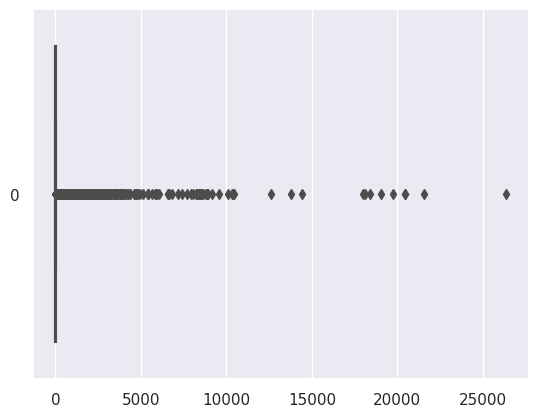

In [219]:
sb.boxplot(all_stems_df["freq"], orient="h")

As we can see, the distribution is pretty scattered, which a few very popular words, but most words are only used in 1 or 2 songs.

### Document-Term Matrix
We will create a Document-Term Matrix with  

| Rows | Columns | Value                         |
|------|---------|-------------------------------|
| Song | Word    | Frequency of word in the Song |

This can be done easily with `CountVectorizer` in `sklearn`



In [220]:
# We have already preprocessed and tokenized our lyrics, so we will override the
# tokenizer and preprocessor in CountVectorizer to not do anything
count_vectorizer = CountVectorizer(tokenizer=lambda x:x,
                                   token_pattern=None,
                                   preprocessor=lambda x:x)

stems_freq = count_vectorizer.fit_transform(pop_country["stems"]) # Document-Term Matrix
stems = count_vectorizer.get_feature_names_out()


In [221]:
print(len(all_stems), len(stems))

18271 18271


### Dimensionality Reduction
Some of the 18,271 words are probably not useful, so we will select just a subset of these to train on.

To do that, we can decide which of these words is most "important" in predicting the popularity level by applying the **Chi-squared test**.

In [226]:
selector = SelectKBest(chi2, k=15000)
stems_freq_transformed = selector.fit_transform(stems_freq, pop_country["popularity_level"])

In [227]:
selected_stems_mask = selector.get_support()
selected_stems = stems[selected_stems_mask]

# Machine Learning

### Feature Selection

In [228]:
pop_country.columns

Index(['genre', 'artist_name', 'track_name', 'track_id', 'popularity',
       'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence', 'lyrics',
       'lyrics_info', 'popularity_level', 'tokenized', 'stems'],
      dtype='object')

The mode is pretty much the only feature that seem to be correlated to the popularity, hence we will be using just that and the lyrics to fit our model.

The Mode will be encoded in the following format
- 0: Major
- 1: Minor

In [229]:
pop_country["mode_encoded"] = pop_country["mode"].apply(lambda mode: 1 if (mode=="Major") else 0)
pop_country[["mode", "mode_encoded"]]

,mode,mode_encoded
107804,Minor,0
107802,Minor,0
107829,Major,1
107808,Major,1
107838,Major,1
...,...,...
212806,Major,1
7471,Major,1
216687,Major,1
215996,Major,1


Encoding Data into numeric matrix for training.

Matrix will be in the form

| stem1 | stem2 | ... | mode | time signature |
|-------|-------|-----|------|------------------|
| 1     | 0     | ... | 1    | 3                |
| ...   | ...   | ... | ...  | ...              |

In [230]:
features_set = np.hstack((stems_freq_transformed.toarray(), np.array([pop_country["mode_encoded"].to_numpy()]).T))

In [231]:
print(features_set)
print(features_set.shape)

[[ 4  0  0 ...  0  0  0]
 [ 2  0  0 ...  0  0  0]
 [18  0  0 ...  0  0  1]
 ...
 [ 0  0  0 ...  0  0  1]
 [ 1  0  0 ...  0  0  1]
 [ 0  0  0 ...  0  0  1]]
(9093, 15001)


## Model Selection

We will choose between Multinomial Naive Bayes and Bernoulli Naive Bayes.

The difference is that Multinomial Model acts with occurence counts, while the Bernoulli Model binarizes all features, meaning it only takes into account the presence of a word and not it's count.

In [232]:
bernoulli = BernoulliNB()
multinomial = MultinomialNB()

#### Cross-Validation
Given that we have a relatively small data-set, we will be performing multiple different train-test splits on the data then comparing the accuracies their respective test set.

This is known as cross-validation, and `sklearn` provides a convenient `cross_val_score` function to split the data into `k` different train-test splits (by default using the `StratifiedKFold` which ensures same proportion of reponse variable classes (`popularity_level`) as the entire dataset.

In [233]:
# 5-Fold Cross-Validation
bernoulli_scores = cross_val_score(bernoulli, features_set, pop_country["popularity_level"], cv=5)      
multinomial_scores = cross_val_score(multinomial, features_set, pop_country["popularity_level"], cv=5)

print("Benoulli Test Set Accuracy:")
print(f"\tMean: {bernoulli_scores.mean()}")
print(f"\tStandard Deviation: {bernoulli_scores.std()}")


print("Multinomial Test Set Accuracy:")
print(f"\tMean: {multinomial_scores.mean()}")
print(f"\tStandard Deviation: {multinomial_scores.std()}")

Benoulli Test Set Accuracy:
	Mean: 0.3368496937654183
	Standard Deviation: 0.011992435647182501
Multinomial Test Set Accuracy:
	Mean: 0.3287115407527558
	Standard Deviation: 0.012285173361276032


### Selected Model: Bernoulli Naive Bayes
We picked the Nayes Bayes because it has a higher mean accuracy on the test sets after cross-validation.

We can visualise how well this model does on a specific train test split:

In [234]:
train_features, test_features, train_popularity, test_popularity = train_test_split(features_set, pop_country["popularity_level"])
print(f"Train Size: {len(train_features)}\tTest Size: {len(test_features)}")

Train Size: 6819	Test Size: 2274


In [235]:
classifier = bernoulli
classifier.fit(train_features, train_popularity)

popularity_train_pred = classifier.predict(train_features)
popularity_test_pred = classifier.predict(test_features)

print(f"Classification Accuracy (Train Dataset): {classifier.score(train_features, train_popularity)}")
print(f"Classification Accuracy (Test Dataset): {classifier.score(test_features, test_popularity)}")

Classification Accuracy (Train Dataset): 0.6716527350051327
Classification Accuracy (Test Dataset): 0.3518029903254178


#### Confusion Matrix

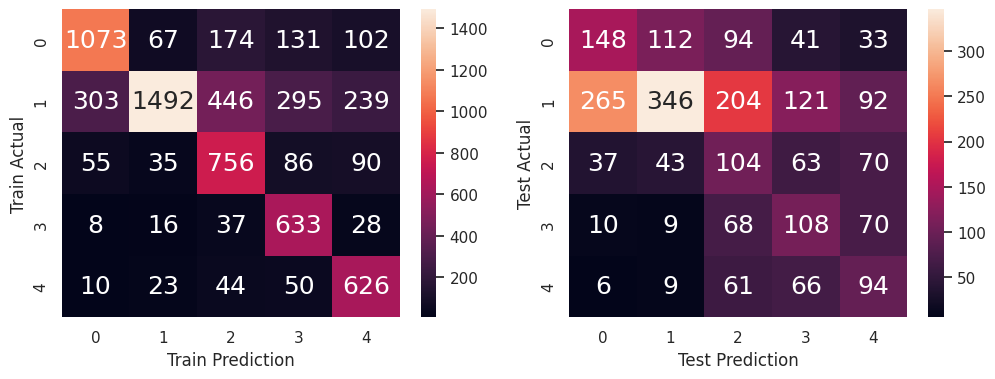

In [236]:
f, axes = plt.subplots(1, 2, figsize=(12,4))

sb.heatmap(confusion_matrix(popularity_train_pred, train_popularity), annot=True, fmt=".0f", annot_kws={"size":18}, ax=axes[0])
sb.heatmap(confusion_matrix(popularity_test_pred, test_popularity), annot=True, fmt=".0f", annot_kws={"size":18}, ax=axes[1])

axes[0].set_xlabel("Train Prediction");
axes[0].set_ylabel("Train Actual");
axes[1].set_xlabel("Test Prediction");
axes[1].set_ylabel("Test Actual");


# Conclusion
As we can see from the confusion matrix, the model fits the train set relatively well, with an accuracy of $\approx 0.67$

The model did not perform as well on the test dataset, with an accuracy of just $\approx 0.35$. Despite this, we can complete that the model was somewhat succesful since this is about 15% better than just random chance (5 classes hence 20%).

Furthermore, we can see from the confusion matrix heatmap that the cells around the main diagonal is generally brighter. This means that the model's wrong predictions are generally not too far off the correct guess. (i.e. most of the misclassified `popularity_level` 1 was classified as either 0 or 2)